### In this script, DBN is run on the combined sessions, combined for each condition
### In this script, DBN is run with 1s time bin, 3 time lag 
### In this script, the animal tracking is done with only one camera - camera 2 (middle) 
### This script analyze the autolever sessions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
import scipy
import scipy.stats as st
import sklearn
from sklearn.neighbors import KernelDensity
import string
import warnings
import pickle

import os
import glob
import random
from time import time

from pgmpy.models import BayesianModel
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch,BicScore
from pgmpy.base import DAG
import networkx as nx


### function - get body part location for each pair of cameras

In [2]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair
from ana_functions.body_part_locs_singlecam import body_part_locs_singlecam

### function - align the two cameras

In [3]:
from ana_functions.camera_align import camera_align       

### function - merge the two pairs of cameras

In [4]:
from ana_functions.camera_merge import camera_merge

### function - find social gaze time point

In [5]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint
from ana_functions.find_socialgaze_timepoint_singlecam import find_socialgaze_timepoint_singlecam
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody import find_socialgaze_timepoint_singlecam_wholebody
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody_2 import find_socialgaze_timepoint_singlecam_wholebody_2


### function - define time point of behavioral events

In [6]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint
from ana_functions.bhv_events_timepoint_singlecam import bhv_events_timepoint_singlecam
from ana_functions.bhv_events_timepoint_singlecam_otherlever import bhv_events_timepoint_singlecam_otherlever

### function - plot behavioral events

In [7]:
from ana_functions.plot_bhv_events import plot_bhv_events
from ana_functions.plot_bhv_events_levertube import plot_bhv_events_levertube
from ana_functions.draw_self_loop import draw_self_loop
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection
from ana_functions.plot_gaze_along_phase_of_continuous_bhv_var_singlecam import plot_gaze_along_phase_of_continuous_bhv_var_singlecam


### function - make demo videos with skeleton and inportant vectors

In [8]:
from ana_functions.tracking_video_singlecam_demo import tracking_video_singlecam_demo
from ana_functions.tracking_video_singlecam_wholebody_demo import tracking_video_singlecam_wholebody_demo

### function - interval between all behavioral events

In [9]:
from ana_functions.bhv_events_interval import bhv_events_interval
from ana_functions.bhv_events_interval import bhv_events_interval_certainEdges

### function - train the dynamic bayesian network - multi time lag (3 lags)

In [10]:
from ana_functions.train_DBN_multiLag_autolever import train_DBN_multiLag
from ana_functions.train_DBN_multiLag_autolever import train_DBN_multiLag_create_df_only
from ana_functions.train_DBN_multiLag_autolever import train_DBN_multiLag_training_only
from ana_functions.train_DBN_multiLag_autolever import graph_to_matrix
from ana_functions.train_DBN_multiLag_autolever import get_weighted_dags
from ana_functions.train_DBN_multiLag_autolever import get_significant_edges
from ana_functions.train_DBN_multiLag_autolever import threshold_edges
from ana_functions.train_DBN_multiLag_autolever import Modulation_Index
from ana_functions.EfficientTimeShuffling import EfficientShuffle
from ana_functions.AicScore import AicScore

## Analyze each session

### prepare the basic behavioral data (especially the time stamps for each bhv events)

In [11]:
# instead of using gaze angle threshold, use the target rectagon to deside gaze info
# ...need to update
sqr_thres_tubelever = 75 # draw the square around tube and lever
sqr_thres_face = 1.15 # a ratio for defining face boundary
sqr_thres_body = 4 # how many times to enlongate the face box boundry to the body


# get the fps of the analyzed video
fps = 30

# frame number of the demo video
# nframes = 0.5*30 # second*30fps
nframes = 2*30 # second*30fps

# re-analyze the video or not
reanalyze_video = 0
redo_anystep = 0

# only analyze the best (five) sessions for each conditions
do_bestsession = 1
if do_bestsession:
    savefile_sufix = '_bestsessions_autolever'
else:
    savefile_sufix = '_autolever'
    
# all the videos (no misaligned ones)
# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used

# dodson scorch
if 0:
    if not do_bestsession:
        dates_list = [                      
                     ]
        session_start_times = [                                
                              ] # in second
    elif do_bestsession:
        # pick only five sessions for each conditions
        dates_list = [        
                       "20220915","20220920","20221010","20230208",
            
                       "20221205","20221206","20221209","20221214","20230112",
                      
                      "20230327","20230328","20230331","20230403","20230404",
                      "20230405","20230406",
                     ]
        session_start_times = [                 
                                 0.00,33.03, 6.50, 0.00, 
            
                                 0.00, 0.00, 21.7, 17.0, 14.2, 
            
                                 30.0, 34.8, 29.2, 27.0, 28.0,
                                 26.5, 23.0,                                
                              ] # in second
    
    animal1_fixedorder = ['dodson']
    animal2_fixedorder = ['scorch']

    animal1_filename = "Dodson"
    animal2_filename = "Scorch"
    
# eddie sparkle
if 0:
    if not do_bestsession:
        dates_list = [                                            
                   ]
        session_start_times = [                                                                 
                              ] # in second
    elif do_bestsession:   
        dates_list = [
                      "20221122",  "20221125",  
                      
                      "20230321",  "20230322",  "20230324",  "20230327",  "20230328",
            
                      "20230524",  "20230526",  "20230529",  "20230531",  "20230605", 
                      "20230606",  "20230608",  "20230609",  "20230613",  "20230615",
                   ]
        session_start_times = [ 
                                  8.00,  38.00, 
                                  
                                  7.00,   7.50,  5.50, 11.00,  9.00,
                            
                                  25.0,   34.0,  29.0,  12.8,  26.0,  
                                  24.1,   21.0,  23.0,  29.0,  24.5,
                              ] # in second
    
    animal1_fixedorder = ['eddie']
    animal2_fixedorder = ['sparkle']

    animal1_filename = "Eddie"
    animal2_filename = "Sparkle"
    
# ginger kanga
if 1:
    if not do_bestsession:
        dates_list = [                     
                   ]
        session_start_times = [                            
                              ] # in second 
    elif do_bestsession:   
        dates_list = [
                      "20230214","20230216",

                      "20230412","20230413","20230517",
            
                      "20230616","20230620","20230621","20230622","20230623",
                      "20230626","20230627","20230629","20230703",                    
                   ]
        session_start_times = [ 
                                 0.00, 48.00, 

                                 0.00,  0.00,  0.00, 
            
                                58.20, 60.20, 26.80, 43.50, 40.00,
                                53.00, 51.00, 27.20, 32.20,
                                
                              ] # in second 
    
    animal1_fixedorder = ['ginger']
    animal2_fixedorder = ['kanga']

    animal1_filename = "Ginger"
    animal2_filename = "Kanga"

    
# dannon kanga
if 0:
    if not do_bestsession:
        dates_list = [
                   ]
        session_start_times = [ 
                              ] # in second 
    elif do_bestsession:   
        dates_list = [
                      "20230718","20230720","20230914",
            
                      "20230907","20230915","20230918","20230926","20230928",
                      "20231002","20231010",
            
                      "20240201","20240212","20240214","20240215","20240222",
                      "20240223","20240226",
            
                   ]
        session_start_times = [ 
                                    0,     0,     0, 
            
                                    0,     0,     0,     0,     0,     
                                    0,     0,
            
                                    21.00, 45.50, 19.00, 22.20, 28.20,
                                    25.50, 16.10,
                              ] # in second 
    
    animal1_fixedorder = ['dannon']
    animal2_fixedorder = ['kanga']

    animal1_filename = "Dannon"
    animal2_filename = "Kanga"
    
    
    
#    
# dates_list = ["20230718"]
# session_start_times = [0.00] # in second

ndates = np.shape(dates_list)[0]

session_start_frames = session_start_times * fps # fps is 30Hz

totalsess_time = 600

# video tracking results info
animalnames_videotrack = ['dodson','scorch'] # does not really mean dodson and scorch, instead, indicate animal1 and animal2
bodypartnames_videotrack = ['rightTuft','whiteBlaze','leftTuft','rightEye','leftEye','mouth']


# which camera to analyzed
cameraID = 'camera-2'
cameraID_short = 'cam2'


# location of levers and tubes for camera 2
# get this information using DLC animal tracking GUI, the results are stored: 
# /home/ws523/marmoset_tracking_DLCv2/marmoset_tracking_with_lever_tube-weikang-2023-04-13/labeled-data/
considerlevertube = 1
considertubeonly = 0
# # camera 1
# lever_locs_camI = {'dodson':np.array([645,600]),'scorch':np.array([425,435])}
# tube_locs_camI  = {'dodson':np.array([1350,630]),'scorch':np.array([555,345])}
# # camera 2
lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
tube_locs_camI  = {'dodson':np.array([1550,515]),'scorch':np.array([350,515])}
# # lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
# # tube_locs_camI  = {'dodson':np.array([1650,490]),'scorch':np.array([250,490])}
# # camera 3
# lever_locs_camI = {'dodson':np.array([1580,440]),'scorch':np.array([1296,540])}
# tube_locs_camI  = {'dodson':np.array([1470,375]),'scorch':np.array([805,475])}


if np.shape(session_start_times)[0] != np.shape(dates_list)[0]:
    exit()

    
# define bhv events summarizing variables     
tasktypes_all_dates = np.zeros((ndates,1))
coopthres_all_dates = np.zeros((ndates,1))

succ_rate_all_dates = np.zeros((ndates,1))
interpullintv_all_dates = np.zeros((ndates,1))
trialnum_all_dates = np.zeros((ndates,1))

owgaze1_num_all_dates = np.zeros((ndates,1))
owgaze2_num_all_dates = np.zeros((ndates,1))
mtgaze1_num_all_dates = np.zeros((ndates,1))
mtgaze2_num_all_dates = np.zeros((ndates,1))
pull1_num_all_dates = np.zeros((ndates,1))
pull2_num_all_dates = np.zeros((ndates,1))

gazelever1_num_all_dates = np.zeros((ndates,1))
gazelever2_num_all_dates = np.zeros((ndates,1))
gazetube1_num_all_dates = np.zeros((ndates,1))
gazetube2_num_all_dates = np.zeros((ndates,1))

gazeotherlever1_num_all_dates = np.zeros((ndates,1))
gazeotherlever2_num_all_dates = np.zeros((ndates,1))

session_recordtime_all_dates = np.zeros((ndates,1))

bhv_intv_all_dates = dict.fromkeys(dates_list, [])
pull_edges_intv_all_dates = dict.fromkeys(dates_list, [])

gazeDist_phaseof_contbhvvar_all_dates = dict.fromkeys(dates_list, [])

# where to save the summarizing data
data_saved_folder = '/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/3d_recontruction_analysis_self_and_coop_task_data_saved/'


    

In [12]:
# basic behavior analysis (define time stamps for each bhv events, etc)

try:
    if redo_anystep:
        dummy
    
    # load saved data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    
    with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull2_num_all_dates = pickle.load(f)
        
    with open(data_saved_subfolder+'/gazelever1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        gazelever1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/gazelever2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        gazelever2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/gazetube1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        gazetube1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/gazetube2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        gazetube2_num_all_dates = pickle.load(f)
    
    with open(data_saved_subfolder+'/gazeotherlever1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        gazeotherlever1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/gazeotherlever2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        gazeotherlever2_num_all_dates = pickle.load(f)
    
    with open(data_saved_subfolder+'/session_recordtime_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        session_recordtime_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        tasktypes_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        coopthres_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        succ_rate_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        interpullintv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        trialnum_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        bhv_intv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull_edges_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull_edges_intv_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/gazeDist_phaseof_contbhvvar_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        gazeDist_phaseof_contbhvvar_all_dates = pickle.load(f)   

    print('all data from all dates are loaded')

except:

    print('analyze all dates')

    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        session_start_time = session_start_times[idate]

        # folder and file path
        camera12_analyzed_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/"
        camera23_analyzed_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera23/"
        
        singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
        try: 
            bodyparts_camI_camIJ = camera12_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,date_tgt)
            video_file_original = camera12_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"
        except:
            bodyparts_camI_camIJ = camera23_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,date_tgt)
            video_file_original = camera23_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"        
        
        #
        recordedtime = np.shape(bodyparts_locs_camI[('dodson','rightTuft')])[0]/fps # - session_start_time
        session_recordtime_all_dates[idate] = recordedtime
        
        
        # load behavioral results
        try:
            try:
                bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])
            except:
                bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])
        except:
            try:
                bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_forceManipulation_task/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])
            except:
                bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_forceManipulation_task/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])

        # get animal info from the session information
        animal1 = session_info['lever1_animal'][0].lower()
        animal2 = session_info['lever2_animal'][0].lower()

        
        # get task type and cooperation threshold
        try:
            coop_thres = session_info["pulltime_thres"][0]
            tasktype = session_info["task_type"][0]
        except:
            coop_thres = 0
            tasktype = 1
        tasktypes_all_dates[idate] = tasktype
        coopthres_all_dates[idate] = coop_thres   

        # clean up the trial_record
        warnings.filterwarnings('ignore')
        trial_record_clean = pd.DataFrame(columns=trial_record.columns)
        for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
            # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
            trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial+1].iloc[[0]])
        trial_record_clean = trial_record_clean.reset_index(drop = True)

        # change bhv_data time to the absolute time
        time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
        for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
            ind = bhv_data["trial_number"]==itrial+1
            new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
            time_points_new["time_points_new"][ind] = new_time_itrial
        bhv_data["time_points"] = time_points_new["time_points_new"]
        bhv_data = bhv_data[bhv_data["time_points"] != 0]


        # analyze behavior results
        # succ_rate_all_dates[idate] = np.sum(trial_record_clean["rewarded"]>0)/np.shape(trial_record_clean)[0]
        succ_rate_all_dates[idate] = np.sum((bhv_data['behavior_events']==3)|(bhv_data['behavior_events']==4))/np.sum((bhv_data['behavior_events']==1)|(bhv_data['behavior_events']==2))
        trialnum_all_dates[idate] = np.shape(trial_record_clean)[0]
        #
        pullid = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["behavior_events"])
        pulltime = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["time_points"])
        pullid_diff = np.abs(pullid[1:] - pullid[0:-1])
        pulltime_diff = pulltime[1:] - pulltime[0:-1]
        interpull_intv = pulltime_diff[pullid_diff==1]
        interpull_intv = interpull_intv[interpull_intv<10]
        mean_interpull_intv = np.nanmean(interpull_intv)
        std_interpull_intv = np.nanstd(interpull_intv)
        #
        interpullintv_all_dates[idate] = mean_interpull_intv
        # 
        if np.isin(animal1,animal1_fixedorder):
            pull1_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==1) 
            pull2_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==2)
        else:
            pull1_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==2) 
            pull2_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==1)

        
        # load behavioral event results
        try:
            # dummy
            print('load social gaze with '+cameraID+' only of '+date_tgt)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
                output_look_ornot = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'rb') as f:
                output_allvectors = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'rb') as f:
                output_allangles = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_key_locations.pkl', 'rb') as f:
                output_key_locations = pickle.load(f)
        except:   
            print('analyze social gaze with '+cameraID+' only of '+date_tgt)
            # get social gaze information 
            output_look_ornot, output_allvectors, output_allangles = find_socialgaze_timepoint_singlecam_wholebody(bodyparts_locs_camI,lever_locs_camI,tube_locs_camI,
                                                                                                                   considerlevertube,considertubeonly,sqr_thres_tubelever,
                                                                                                                   sqr_thres_face,sqr_thres_body)
            output_key_locations = find_socialgaze_timepoint_singlecam_wholebody_2(bodyparts_locs_camI,lever_locs_camI,tube_locs_camI,considerlevertube)
            
            # save data
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            #
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'wb') as f:
                pickle.dump(output_look_ornot, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'wb') as f:
                pickle.dump(output_allvectors, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'wb') as f:
                pickle.dump(output_allangles, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_key_locations.pkl', 'wb') as f:
                pickle.dump(output_key_locations, f)
  

        look_at_other_or_not_merge = output_look_ornot['look_at_other_or_not_merge']
        look_at_tube_or_not_merge = output_look_ornot['look_at_tube_or_not_merge']
        look_at_lever_or_not_merge = output_look_ornot['look_at_lever_or_not_merge']
        look_at_otherlever_or_not_merge = output_look_ornot['look_at_otherlever_or_not_merge']
        look_at_otherface_or_not_merge = output_look_ornot['look_at_otherface_or_not_merge']
        
        # change the unit to second
        session_start_time = session_start_times[idate]
        look_at_other_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_other_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_lever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_lever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_tube_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_tube_or_not_merge['dodson'])[0],1)/fps - session_start_time 
        look_at_otherlever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_otherlever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_otherface_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_otherface_or_not_merge['dodson'])[0],1)/fps - session_start_time

        
        # find time point of behavioral events
        # output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_other_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
        output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_otherface_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
        time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
        time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
        oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
        oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
        mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
        mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']
        time_point_lever1 = output_time_points_levertube['time_point_lookatlever1']
        time_point_lever2 = output_time_points_levertube['time_point_lookatlever2']
        time_point_tube1 = output_time_points_levertube['time_point_lookattube1']
        time_point_tube2 = output_time_points_levertube['time_point_lookattube2']
            
        output_time_points_otherlever = bhv_events_timepoint_singlecam_otherlever(bhv_data, look_at_otherlever_or_not_merge)
        time_point_otherlever1 = output_time_points_otherlever['time_point_lookatotherlever1']
        time_point_otherlever2 = output_time_points_otherlever['time_point_lookatotherlever2']
        
        
            
        #
        if np.isin(animal1,animal1_fixedorder):
            owgaze1_num_all_dates[idate] = np.shape(oneway_gaze1)[0]#/(min_length/fps)
            owgaze2_num_all_dates[idate] = np.shape(oneway_gaze2)[0]#/(min_length/fps)
            mtgaze1_num_all_dates[idate] = np.shape(mutual_gaze1)[0]#/(min_length/fps)
            mtgaze2_num_all_dates[idate] = np.shape(mutual_gaze2)[0]#/(min_length/fps)
            gazelever1_num_all_dates[idate] = np.shape(time_point_lever1)[0]
            gazelever2_num_all_dates[idate] = np.shape(time_point_lever2)[0]
            gazetube1_num_all_dates[idate] = np.shape(time_point_tube1)[0]
            gazetube2_num_all_dates[idate] = np.shape(time_point_tube2)[0]
            
            gazeotherlever1_num_all_dates[idate] = np.shape(time_point_otherlever1)[0]
            gazeotherlever2_num_all_dates[idate] = np.shape(time_point_otherlever2)[0]
        else:
            owgaze1_num_all_dates[idate] = np.shape(oneway_gaze2)[0]#/(min_length/fps)
            owgaze2_num_all_dates[idate] = np.shape(oneway_gaze1)[0]#/(min_length/fps)
            mtgaze1_num_all_dates[idate] = np.shape(mutual_gaze2)[0]#/(min_length/fps)
            mtgaze2_num_all_dates[idate] = np.shape(mutual_gaze1)[0]#/(min_length/fps)
            gazelever1_num_all_dates[idate] = np.shape(time_point_lever2)[0]
            gazelever2_num_all_dates[idate] = np.shape(time_point_lever1)[0]
            gazetube1_num_all_dates[idate] = np.shape(time_point_tube2)[0]
            gazetube2_num_all_dates[idate] = np.shape(time_point_tube1)[0]
            
            gazeotherlever1_num_all_dates[idate] = np.shape(time_point_otherlever2)[0]
            gazeotherlever2_num_all_dates[idate] = np.shape(time_point_otherlever1)[0]

        
        # plot and analyze the gaze distribution along the phase of continous behavioral variables
        if 1:
            fig_savepath = data_saved_folder+'/	bhv_events_continuous_variables_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'+cameraID+'/'+date_tgt+'/'   
            if not os.path.exists(fig_savepath):
                os.makedirs(fig_savepath)
            fig_savepath = fig_savepath + date_tgt

            doActvePeri = 1
            doGazeStart = 1
            savefig = 1
            #
            gazeDist_phaseof_contbhvvar_summary = plot_gaze_along_phase_of_continuous_bhv_var_singlecam(fig_savepath, savefig, animal1, animal2, session_start_time, 
                                                                            time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, 
                                                                            mutual_gaze1, mutual_gaze2, animalnames_videotrack, output_look_ornot, 
                                                                            output_allvectors, output_allangles, output_key_locations, doActvePeri, doGazeStart)
            #
            gazeDist_phaseof_contbhvvar_all_dates[date_tgt] = gazeDist_phaseof_contbhvvar_summary

        
        # analyze the events interval, especially for the pull to other and other to pull interval
        # could be used for define time bin for DBN
        if np.isin(animal1,animal1_fixedorder):
            _,_,_,pullTOother_itv, otherTOpull_itv = bhv_events_interval(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, 
                                                                         oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
            #
            pull_other_pool_itv = np.concatenate((pullTOother_itv,otherTOpull_itv))
            bhv_intv_all_dates[date_tgt] = {'pull_to_other':pullTOother_itv,'other_to_pull':otherTOpull_itv,
                            'pull_other_pooled': pull_other_pool_itv}
            
            all_pull_edges_intervals = bhv_events_interval_certainEdges(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, 
                                                                        oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
            pull_edges_intv_all_dates[date_tgt] = all_pull_edges_intervals
        else:
            _,_,_,pullTOother_itv, otherTOpull_itv = bhv_events_interval(totalsess_time, session_start_time, time_point_pull2, time_point_pull1, 
                                                                         oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)
            #
            pull_other_pool_itv = np.concatenate((pullTOother_itv,otherTOpull_itv))
            bhv_intv_all_dates[date_tgt] = {'pull_to_other':pullTOother_itv,'other_to_pull':otherTOpull_itv,
                            'pull_other_pooled': pull_other_pool_itv}
            
            all_pull_edges_intervals = bhv_events_interval_certainEdges(totalsess_time, session_start_time, time_point_pull2, time_point_pull1, 
                                                                        oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)
            pull_edges_intv_all_dates[date_tgt] = all_pull_edges_intervals
   
        
        

    # save data
    if 1:
        
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)
                
        # with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
        #     pickle.dump(DBN_input_data_alltypes, f)

        with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull1_num_all_dates, f)
        with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull2_num_all_dates, f)
            
        with open(data_saved_subfolder+'/gazelever1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(gazelever1_num_all_dates, f)
        with open(data_saved_subfolder+'/gazelever2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(gazelever2_num_all_dates, f)
        with open(data_saved_subfolder+'/gazetube1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(gazetube1_num_all_dates, f)
        with open(data_saved_subfolder+'/gazetube2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(gazetube2_num_all_dates, f)
         
        with open(data_saved_subfolder+'/session_recordtime_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(session_recordtime_all_dates, f)
        
        with open(data_saved_subfolder+'/gazeotherlever1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(gazeotherlever1_num_all_dates, f)
        with open(data_saved_subfolder+'/gazeotherlever2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(gazeotherlever2_num_all_dates, f)
        

        with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(tasktypes_all_dates, f)
        with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(coopthres_all_dates, f)
        with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(succ_rate_all_dates, f)
        with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(interpullintv_all_dates, f)
        with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(trialnum_all_dates, f)
        with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(bhv_intv_all_dates, f)
        with open(data_saved_subfolder+'/pull_edges_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull_edges_intv_all_dates, f)
    
        with open(data_saved_subfolder+'/gazeDist_phaseof_contbhvvar_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(gazeDist_phaseof_contbhvvar_all_dates, f)
    

all data from all dates are loaded


### prepare the input data for DBN

In [13]:
# define DBN related summarizing variables
# remember, animal1 and animal2 are already animal ID fixed (different from lever 1 and 2!!)
DBN_group_typenames = ['self','coop(1s)','animal1_autolever','animal2_autolever']
DBN_group_typeIDs  =  [1,3,8,9]
DBN_group_coopthres = [0,1,1,1]
nDBN_groups = np.shape(DBN_group_typenames)[0]

# define DBN related summarizing variables
DBN_input_data_alltypes = dict.fromkeys(DBN_group_typenames, [])

prepare_input_data = 0

# DBN resolutions (make sure they are the same as in the later part of the code)
totalsess_time = 600 # total session time in s
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]

mergetempRos = 0

# # train the dynamic bayesian network - Alec's model 
#   prepare the multi-session table; one time lag; multi time steps (temporal resolution) as separate files

# prepare the DBN input data
if prepare_input_data:
    
    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        session_start_time = session_start_times[idate]
        session_recordtime_all = session_recordtime_all_dates[idate]
        
        # totalsess_time = np.ceil(session_recordtime_all-session_start_time)
        

        # load behavioral results
        try:
            try:
                bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])
            except:
                bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])
        except:    
            try:
                bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_forceManipulation_task/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])
            except:
                bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_forceManipulation_task/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])
            
        # get animal info
        animal1 = session_info['lever1_animal'][0].lower()
        animal2 = session_info['lever2_animal'][0].lower()
        
        # clean up the trial_record
        warnings.filterwarnings('ignore')
        trial_record_clean = pd.DataFrame(columns=trial_record.columns)
        for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
            # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
            trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial+1].iloc[[0]])
        trial_record_clean = trial_record_clean.reset_index(drop = True)

        # change bhv_data time to the absolute time
        time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
        for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
            ind = bhv_data["trial_number"]==itrial+1
            new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
            time_points_new["time_points_new"][ind] = new_time_itrial
        bhv_data["time_points"] = time_points_new["time_points_new"]
        bhv_data = bhv_data[bhv_data["time_points"] != 0]
            
        # get task type and cooperation threshold
        try:
            coop_thres = session_info["pulltime_thres"][0]
            tasktype = session_info["task_type"][0]
        except:
            coop_thres = 0
            tasktype = 1

        # load behavioral event results
        print('load social gaze with '+cameraID+' only of '+date_tgt)
        with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
            output_look_ornot = pickle.load(f)
        with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'rb') as f:
            output_allvectors = pickle.load(f)
        with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'rb') as f:
            output_allangles = pickle.load(f)  
        #
        look_at_other_or_not_merge = output_look_ornot['look_at_other_or_not_merge']
        look_at_tube_or_not_merge = output_look_ornot['look_at_tube_or_not_merge']
        look_at_lever_or_not_merge = output_look_ornot['look_at_lever_or_not_merge']
        look_at_otherlever_or_not_merge = output_look_ornot['look_at_otherlever_or_not_merge']
        look_at_otherface_or_not_merge = output_look_ornot['look_at_otherface_or_not_merge']
        
        # change the unit to second
        session_start_time = session_start_times[idate]
        look_at_other_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_other_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_lever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_lever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_tube_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_tube_or_not_merge['dodson'])[0],1)/fps - session_start_time 
        look_at_otherlever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_otherlever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_otherface_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_otherface_or_not_merge['dodson'])[0],1)/fps - session_start_time
        
        # find time point of behavioral events
        # output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_other_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
        output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_otherface_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
        time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
        time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
        oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
        oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
        mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
        mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']   
        time_point_lever1 = output_time_points_levertube['time_point_lookatlever1']
        time_point_lever2 = output_time_points_levertube['time_point_lookatlever2']
        time_point_tube1 = output_time_points_levertube['time_point_lookattube1']
        time_point_tube2 = output_time_points_levertube['time_point_lookattube2']
            
        output_time_points_otherlever = bhv_events_timepoint_singlecam_otherlever(bhv_data, look_at_otherlever_or_not_merge)
        time_point_otherlever1 = output_time_points_otherlever['time_point_lookatotherlever1']
        time_point_otherlever2 = output_time_points_otherlever['time_point_lookatotherlever2']

        
        if mergetempRos:
            temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
            # use bhv event to decide temporal resolution
            #
            #low_lim,up_lim,_ = bhv_events_interval(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
            #temp_resolus = temp_resolus = np.arange(low_lim,up_lim,0.1)
           
        #
        ntemp_reses = np.shape(temp_resolus)[0]           

        
        # try different temporal resolutions
        for temp_resolu in temp_resolus:
            bhv_df = []

            if np.isin(animal1,animal1_fixedorder):
                bhv_df_itr,_,_ = train_DBN_multiLag_create_df_only(totalsess_time, session_start_time, temp_resolu, 
                                                                   time_point_pull1, time_point_pull2, 
                                                                   oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2,
                                                                   time_point_otherlever1, time_point_otherlever2)
            else:
                bhv_df_itr,_,_ = train_DBN_multiLag_create_df_only(totalsess_time, session_start_time, temp_resolu, 
                                                                   time_point_pull2, time_point_pull1, 
                                                                   oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1,
                                                                   time_point_otherlever2, time_point_otherlever1)     

            if len(bhv_df)==0:
                bhv_df = bhv_df_itr
            else:
                bhv_df = pd.concat([bhv_df,bhv_df_itr])                   
                bhv_df = bhv_df.reset_index(drop=True)        

            # merge sessions from the same condition
            for iDBN_group in np.arange(0,nDBN_groups,1):
                iDBN_group_typename = DBN_group_typenames[iDBN_group] 
                iDBN_group_typeID =  DBN_group_typeIDs[iDBN_group] 
                iDBN_group_cothres = DBN_group_coopthres[iDBN_group] 

                # merge sessions 
                if (tasktype!=3):
                    if (tasktype==iDBN_group_typeID):
                        if (len(DBN_input_data_alltypes[iDBN_group_typename])==0):
                            DBN_input_data_alltypes[iDBN_group_typename] = bhv_df
                        else:
                            DBN_input_data_alltypes[iDBN_group_typename] = pd.concat([DBN_input_data_alltypes[iDBN_group_typename],bhv_df])
                else:
                    if (coop_thres==iDBN_group_cothres):
                        if (len(DBN_input_data_alltypes[iDBN_group_typename])==0):
                            DBN_input_data_alltypes[iDBN_group_typename] = bhv_df
                        else:
                            DBN_input_data_alltypes[iDBN_group_typename] = pd.concat([DBN_input_data_alltypes[iDBN_group_typename],bhv_df])

            
    # save data
    if 1:
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)
        if not mergetempRos:
            with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'sReSo.pkl', 'wb') as f:
                pickle.dump(DBN_input_data_alltypes, f)
        else:
            with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_mergeTempsReSo.pkl', 'wb') as f:
                pickle.dump(DBN_input_data_alltypes, f)     

In [14]:
DBN_input_data_alltypes.keys()
print(np.shape(DBN_input_data_alltypes['self']))
print(np.shape(DBN_input_data_alltypes['coop(1s)']))
print(np.shape(DBN_input_data_alltypes['animal1_autolever']))
print(np.shape(DBN_input_data_alltypes['animal2_autolever']))

(0,)
(0,)
(0,)
(0,)


### run the DBN model on the combined session data set
#### a test run

In [15]:
# run DBN on the large table with merged sessions

mergetempRos = 0 # 1: merge different time bins

moreSampSize = 0 # 1: use more sample size (more than just minimal row number and max row number)

num_starting_points = 1 # number of random starting points/graphs
nbootstraps = 1

if 0:

    if moreSampSize:
        # different data (down/re)sampling numbers
        samplingsizes = np.arange(1100,3000,100)
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
        nsamplings = np.shape(samplingsizes)[0]

    weighted_graphs_diffTempRo_diffSampSize = {}
    weighted_graphs_shuffled_diffTempRo_diffSampSize = {}
    sig_edges_diffTempRo_diffSampSize = {}
    DAGscores_diffTempRo_diffSampSize = {}
    DAGscores_shuffled_diffTempRo_diffSampSize = {}

    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]

    # try different temporal resolutions, remember to use the same settings as in the previous ones
    for temp_resolu in temp_resolus:

        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not mergetempRos:
            with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
                DBN_input_data_alltypes = pickle.load(f)
        else:
            with open(data_saved_subfolder+'//DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_mergeTempsReSo.pkl', 'rb') as f:
                DBN_input_data_alltypes = pickle.load(f)

                
        # only try two sample sizes - minimal row number (require data downsample) and maximal row number (require data upsample)
       
        if not moreSampSize:
            key_to_value_lengths = {k:len(v) for k, v in DBN_input_data_alltypes.items()}
            key_to_value_lengths_array = np.fromiter(key_to_value_lengths.values(),dtype=float)
            key_to_value_lengths_array[key_to_value_lengths_array==0]=np.nan
            min_samplesize = np.nanmin(key_to_value_lengths_array)
            min_samplesize = int(min_samplesize/100)*100
            max_samplesize = np.nanmax(key_to_value_lengths_array)
            max_samplesize = int(max_samplesize/100)*100
            samplingsizes = [min_samplesize,max_samplesize]
            samplingsizes_name = ['min_row_number','max_row_number']   
            nsamplings = np.shape(samplingsizes)[0]
            print(samplingsizes)
                
        # try different down/re-sampling size
        for jj in np.arange(0,nsamplings,1):
        # for jj in np.arange(0,1,1):
            
            isamplingsize = samplingsizes[jj]
            
            DAGs_alltypes = dict.fromkeys(DBN_group_typenames, [])
            DAGs_shuffle_alltypes = dict.fromkeys(DBN_group_typenames, [])
            DAGs_scores_alltypes = dict.fromkeys(DBN_group_typenames, [])
            DAGs_shuffle_scores_alltypes = dict.fromkeys(DBN_group_typenames, [])

            weighted_graphs_alltypes = dict.fromkeys(DBN_group_typenames, [])
            weighted_graphs_shuffled_alltypes = dict.fromkeys(DBN_group_typenames, [])
            sig_edges_alltypes = dict.fromkeys(DBN_group_typenames, [])

            # different session conditions (aka DBN groups)
            for iDBN_group in np.arange(0,nDBN_groups,1):
            # for iDBN_group in np.arange(0,1,1):
                iDBN_group_typename = DBN_group_typenames[iDBN_group] 
                iDBN_group_typeID =  DBN_group_typeIDs[iDBN_group] 
                iDBN_group_cothres = DBN_group_coopthres[iDBN_group] 

                try:
                    bhv_df_all = DBN_input_data_alltypes[iDBN_group_typename]
                    # bhv_df = bhv_df_all.sample(30*100,replace = True, random_state = round(time())) # take the subset for DBN training

                    #Anirban(Alec) shuffle, slow
                    # bhv_df_shuffle, df_shufflekeys = EfficientShuffle(bhv_df,round(time()))


                    # define DBN graph structures; make sure they are the same as in the train_DBN_multiLag
                    colnames = list(bhv_df_all.columns)
                    # remove owgaze, only use lvgaze
                    colnames = [pop for pop in colnames if not pop.startswith('owgaze')]
                    bhv_df_all = bhv_df_all[colnames]
                    #
                    # eventnames = ["pull1","pull2","owgaze1","owgaze2"]
                    eventnames = ["pull1","pull2","lvgaze1","lvgaze2"]
                    nevents = np.size(eventnames)

                    all_pops = list(bhv_df_all.columns)
                    # remove owgaze, only use lvgaze
                    all_pops = [pop for pop in all_pops if not pop.startswith('owgaze')]
                    #
                    from_pops = [pop for pop in all_pops if not pop.endswith('t3')]
                    to_pops = [pop for pop in all_pops if pop.endswith('t3')]
                    causal_whitelist = [(from_pop,to_pop) for from_pop in from_pops for to_pop in to_pops]

                    nFromNodes = np.shape(from_pops)[0]
                    nToNodes = np.shape(to_pops)[0]

                    DAGs_randstart = np.zeros((num_starting_points, nFromNodes, nToNodes))
                    DAGs_randstart_shuffle = np.zeros((num_starting_points, nFromNodes, nToNodes))
                    score_randstart = np.zeros((num_starting_points))
                    score_randstart_shuffle = np.zeros((num_starting_points))

                    # step 1: randomize the starting point for num_starting_points times
                    for istarting_points in np.arange(0,num_starting_points,1):

                        # try different down/re-sampling size
                        bhv_df = bhv_df_all.sample(isamplingsize,replace = True, random_state = istarting_points) # take the subset for DBN training
                        aic = AicScore(bhv_df)

                        #Anirban(Alec) shuffle, slow
                        bhv_df_shuffle, df_shufflekeys = EfficientShuffle(bhv_df,round(time()))
                        aic_shuffle = AicScore(bhv_df_shuffle)

                        np.random.seed(istarting_points)
                        random.seed(istarting_points)
                        starting_edges = random.sample(causal_whitelist, np.random.randint(1,len(causal_whitelist)))
                        starting_graph = DAG()
                        starting_graph.add_nodes_from(nodes=all_pops)
                        starting_graph.add_edges_from(ebunch=starting_edges)

                        best_model,edges,DAGs = train_DBN_multiLag_training_only(bhv_df,starting_graph,colnames,eventnames,from_pops,to_pops)           
                        DAGs[0][np.isnan(DAGs[0])]=0

                        DAGs_randstart[istarting_points,:,:] = DAGs[0]
                        score_randstart[istarting_points] = aic.score(best_model)

                        # step 2: add the shffled data results
                        # shuffled bhv_df
                        best_model,edges,DAGs = train_DBN_multiLag_training_only(bhv_df_shuffle,starting_graph,colnames,eventnames,from_pops,to_pops)           
                        DAGs[0][np.isnan(DAGs[0])]=0

                        DAGs_randstart_shuffle[istarting_points,:,:] = DAGs[0]
                        score_randstart_shuffle[istarting_points] = aic_shuffle.score(best_model)

                    DAGs_alltypes[iDBN_group_typename] = DAGs_randstart 
                    DAGs_shuffle_alltypes[iDBN_group_typename] = DAGs_randstart_shuffle

                    DAGs_scores_alltypes[iDBN_group_typename] = score_randstart
                    DAGs_shuffle_scores_alltypes[iDBN_group_typename] = score_randstart_shuffle

                    weighted_graphs = get_weighted_dags(DAGs_alltypes[iDBN_group_typename],nbootstraps)
                    weighted_graphs_shuffled = get_weighted_dags(DAGs_shuffle_alltypes[iDBN_group_typename],nbootstraps)
                    sig_edges = get_significant_edges(weighted_graphs,weighted_graphs_shuffled)

                    weighted_graphs_alltypes[iDBN_group_typename] = weighted_graphs
                    weighted_graphs_shuffled_alltypes[iDBN_group_typename] = weighted_graphs_shuffled
                    sig_edges_alltypes[iDBN_group_typename] = sig_edges
                    
                except:
                    DAGs_alltypes[iDBN_group_typename] = [] 
                    DAGs_shuffle_alltypes[iDBN_group_typename] = []

                    DAGs_scores_alltypes[iDBN_group_typename] = []
                    DAGs_shuffle_scores_alltypes[iDBN_group_typename] = []

                    weighted_graphs_alltypes[iDBN_group_typename] = []
                    weighted_graphs_shuffled_alltypes[iDBN_group_typename] = []
                    sig_edges_alltypes[iDBN_group_typename] = []
                
            DAGscores_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = DAGs_scores_alltypes
            DAGscores_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = DAGs_shuffle_scores_alltypes

            weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = weighted_graphs_alltypes
            weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = weighted_graphs_shuffled_alltypes
            sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = sig_edges_alltypes

    print(weighted_graphs_diffTempRo_diffSampSize)
            
   

#### run on the entire population

In [16]:
# run DBN on the large table with merged sessions

mergetempRos = 0 # 1: merge different time bins

moreSampSize = 0 # 1: use more sample size (more than just minimal row number and max row number)

num_starting_points = 100 # number of random starting points/graphs
nbootstraps = 95


if moreSampSize:
    # different data (down/re)sampling numbers
    samplingsizes = np.arange(1100,3000,100)
    # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
    # samplingsizes = [100,500]
    # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
    samplingsizes_name = list(map(str, samplingsizes))
    nsamplings = np.shape(samplingsizes)[0]


# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]

# try different temporal resolutions, remember to use the same settings as in the previous ones
for temp_resolu in temp_resolus:

    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not mergetempRos:
        with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
            DBN_input_data_alltypes = pickle.load(f)
    else:
        with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_mergeTempsReSo.pkl', 'rb') as f:
            DBN_input_data_alltypes = pickle.load(f)


    # only try two sample sizes - minimal row number (require data downsample) and maximal row number (require data upsample)
    if not moreSampSize:
        key_to_value_lengths = {k:len(v) for k, v in DBN_input_data_alltypes.items()}
        key_to_value_lengths_array = np.fromiter(key_to_value_lengths.values(),dtype=float)
        key_to_value_lengths_array[key_to_value_lengths_array==0]=np.nan
        min_samplesize = np.nanmin(key_to_value_lengths_array)
        min_samplesize = int(min_samplesize/100)*100
        max_samplesize = np.nanmax(key_to_value_lengths_array)
        max_samplesize = int(max_samplesize/100)*100
        samplingsizes = [min_samplesize,max_samplesize]
        samplingsizes_name = ['min_row_number','max_row_number']   
        nsamplings = np.shape(samplingsizes)[0]
        print(samplingsizes)

        
    # try different down/re-sampling size
    for jj in np.arange(0,nsamplings,1):

            
        try:
            # dumpy
            data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
            if not os.path.exists(data_saved_subfolder):
                os.makedirs(data_saved_subfolder)
            if moreSampSize:
                with open(data_saved_subfolder+'/DAGscores_'+str(temp_resolu)+'TempRo_'+samplingsizes_name[jj]+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
                    DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
                with open(data_saved_subfolder+'/DAGscores_shuffled_'+str(temp_resolu)+'TempRo_'+samplingsizes_name[jj]+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
                    DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
                with open(data_saved_subfolder+'/weighted_graphs_'+str(temp_resolu)+'TempRo_'+samplingsizes_name[jj]+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
                    weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
                with open(data_saved_subfolder+'/weighted_graphs_shuffled_'+str(temp_resolu)+'TempRo_'+samplingsizes_name[jj]+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
                    weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
                with open(data_saved_subfolder+'/sig_edges_'+str(temp_resolu)+'TempRo_'+samplingsizes_name[jj]+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
                    sig_edges_diffTempRo_diffSampSize = pickle.load(f)

            else:
                with open(data_saved_subfolder+'/DAGscores_'+str(temp_resolu)+'TempRo_'+samplingsizes_name[jj]+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
                    DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
                with open(data_saved_subfolder+'/DAGscores_shuffled_'+str(temp_resolu)+'TempRo_'+samplingsizes_name[jj]+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
                    DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
                with open(data_saved_subfolder+'/weighted_graphs_'+str(temp_resolu)+'TempRo_'+samplingsizes_name[jj]+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
                    weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
                with open(data_saved_subfolder+'/weighted_graphs_shuffled_'+str(temp_resolu)+'TempRo_'+samplingsizes_name[jj]+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
                    weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
                with open(data_saved_subfolder+'/sig_edges_'+str(temp_resolu)+'TempRo_'+samplingsizes_name[jj]+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
                    sig_edges_diffTempRo_diffSampSize = pickle.load(f)

            print('load saved DBN fitting results')
            
        except:    
             
            isamplingsize = samplingsizes[jj]
            
            weighted_graphs_diffTempRo_diffSampSize = {}
            weighted_graphs_shuffled_diffTempRo_diffSampSize = {}
            sig_edges_diffTempRo_diffSampSize = {}
            DAGscores_diffTempRo_diffSampSize = {}
            DAGscores_shuffled_diffTempRo_diffSampSize = {}
                      
            DAGs_alltypes = dict.fromkeys(DBN_group_typenames, [])
            DAGs_shuffle_alltypes = dict.fromkeys(DBN_group_typenames, [])
            DAGs_scores_alltypes = dict.fromkeys(DBN_group_typenames, [])
            DAGs_shuffle_scores_alltypes = dict.fromkeys(DBN_group_typenames, [])

            weighted_graphs_alltypes = dict.fromkeys(DBN_group_typenames, [])
            weighted_graphs_shuffled_alltypes = dict.fromkeys(DBN_group_typenames, [])
            sig_edges_alltypes = dict.fromkeys(DBN_group_typenames, [])

            # different session conditions (aka DBN groups)
            for iDBN_group in np.arange(0,nDBN_groups,1):
                iDBN_group_typename = DBN_group_typenames[iDBN_group] 
                iDBN_group_typeID =  DBN_group_typeIDs[iDBN_group] 
                iDBN_group_cothres = DBN_group_coopthres[iDBN_group] 

                try:
                    bhv_df_all = DBN_input_data_alltypes[iDBN_group_typename]
                    # bhv_df = bhv_df_all.sample(30*100,replace = True, random_state = round(time())) # take the subset for DBN training

                    #Anirban(Alec) shuffle, slow
                    # bhv_df_shuffle, df_shufflekeys = EfficientShuffle(bhv_df,round(time()))


                    # define DBN graph structures; make sure they are the same as in the train_DBN_multiLag
                    colnames = list(bhv_df_all.columns)
                    # remove owgaze, only use lvgaze
                    colnames = [pop for pop in colnames if not pop.startswith('owgaze')]
                    bhv_df_all = bhv_df_all[colnames]
                    #
                    eventnames = ["pull1","pull2","lvgaze1","lvgaze2"]
                    nevents = np.size(eventnames)

                    all_pops = list(bhv_df_all.columns)
                    # remove owgaze, only use lvgaze
                    all_pops = [pop for pop in all_pops if not pop.startswith('owgaze')]
                    #
                    from_pops = [pop for pop in all_pops if not pop.endswith('t3')]
                    to_pops = [pop for pop in all_pops if pop.endswith('t3')]
                    causal_whitelist = [(from_pop,to_pop) for from_pop in from_pops for to_pop in to_pops]

                    nFromNodes = np.shape(from_pops)[0]
                    nToNodes = np.shape(to_pops)[0]

                    DAGs_randstart = np.zeros((num_starting_points, nFromNodes, nToNodes))
                    DAGs_randstart_shuffle = np.zeros((num_starting_points, nFromNodes, nToNodes))
                    score_randstart = np.zeros((num_starting_points))
                    score_randstart_shuffle = np.zeros((num_starting_points))

                    # step 1: randomize the starting point for num_starting_points times
                    for istarting_points in np.arange(0,num_starting_points,1):

                        # try different down/re-sampling size
                        bhv_df = bhv_df_all.sample(isamplingsize,replace = True, random_state = istarting_points) # take the subset for DBN training
                        aic = AicScore(bhv_df)

                        #Anirban(Alec) shuffle, slow
                        bhv_df_shuffle, df_shufflekeys = EfficientShuffle(bhv_df,round(time()))
                        aic_shuffle = AicScore(bhv_df_shuffle)

                        np.random.seed(istarting_points)
                        random.seed(istarting_points)
                        starting_edges = random.sample(causal_whitelist, np.random.randint(1,len(causal_whitelist)))
                        starting_graph = DAG()
                        starting_graph.add_nodes_from(nodes=all_pops)
                        starting_graph.add_edges_from(ebunch=starting_edges)

                        best_model,edges,DAGs = train_DBN_multiLag_training_only(bhv_df,starting_graph,colnames,eventnames,from_pops,to_pops)           
                        DAGs[0][np.isnan(DAGs[0])]=0

                        DAGs_randstart[istarting_points,:,:] = DAGs[0]
                        score_randstart[istarting_points] = aic.score(best_model)

                        # step 2: add the shffled data results
                        # shuffled bhv_df
                        best_model,edges,DAGs = train_DBN_multiLag_training_only(bhv_df_shuffle,starting_graph,colnames,eventnames,from_pops,to_pops)           
                        DAGs[0][np.isnan(DAGs[0])]=0

                        DAGs_randstart_shuffle[istarting_points,:,:] = DAGs[0]
                        score_randstart_shuffle[istarting_points] = aic_shuffle.score(best_model)

                    DAGs_alltypes[iDBN_group_typename] = DAGs_randstart 
                    DAGs_shuffle_alltypes[iDBN_group_typename] = DAGs_randstart_shuffle

                    DAGs_scores_alltypes[iDBN_group_typename] = score_randstart
                    DAGs_shuffle_scores_alltypes[iDBN_group_typename] = score_randstart_shuffle

                    weighted_graphs = get_weighted_dags(DAGs_alltypes[iDBN_group_typename],nbootstraps)
                    weighted_graphs_shuffled = get_weighted_dags(DAGs_shuffle_alltypes[iDBN_group_typename],nbootstraps)
                    sig_edges = get_significant_edges(weighted_graphs,weighted_graphs_shuffled)

                    weighted_graphs_alltypes[iDBN_group_typename] = weighted_graphs
                    weighted_graphs_shuffled_alltypes[iDBN_group_typename] = weighted_graphs_shuffled
                    sig_edges_alltypes[iDBN_group_typename] = sig_edges
                    
                except:
                    DAGs_alltypes[iDBN_group_typename] = [] 
                    DAGs_shuffle_alltypes[iDBN_group_typename] = []

                    DAGs_scores_alltypes[iDBN_group_typename] = []
                    DAGs_shuffle_scores_alltypes[iDBN_group_typename] = []

                    weighted_graphs_alltypes[iDBN_group_typename] = []
                    weighted_graphs_shuffled_alltypes[iDBN_group_typename] = []
                    sig_edges_alltypes[iDBN_group_typename] = []
                
                
            DAGscores_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = DAGs_scores_alltypes
            DAGscores_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = DAGs_shuffle_scores_alltypes

            weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = weighted_graphs_alltypes
            weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = weighted_graphs_shuffled_alltypes
            sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = sig_edges_alltypes

            
            # save data
            savedata = 0
            if savedata:    
                data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
                if not os.path.exists(data_saved_subfolder):
                    os.makedirs(data_saved_subfolder)
                if moreSampSize:  
                    with open(data_saved_subfolder+'/DAGscores_'+str(temp_resolu)+'TempRo_'+samplingsizes_name[jj]+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
                        pickle.dump(DAGscores_diffTempRo_diffSampSize, f)
                    with open(data_saved_subfolder+'/DAGscores_shuffled_'+str(temp_resolu)+'TempRo_'+samplingsizes_name[jj]+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
                        pickle.dump(DAGscores_shuffled_diffTempRo_diffSampSize, f)
                    with open(data_saved_subfolder+'/weighted_graphs_'+str(temp_resolu)+'TempRo_'+samplingsizes_name[jj]+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
                        pickle.dump(weighted_graphs_diffTempRo_diffSampSize, f)
                    with open(data_saved_subfolder+'/weighted_graphs_shuffled_'+str(temp_resolu)+'TempRo_'+samplingsizes_name[jj]+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
                        pickle.dump(weighted_graphs_shuffled_diffTempRo_diffSampSize, f)
                    with open(data_saved_subfolder+'/sig_edges_'+str(temp_resolu)+'TempRo_'+samplingsizes_name[jj]+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
                        pickle.dump(sig_edges_diffTempRo_diffSampSize, f)

                else:
                    with open(data_saved_subfolder+'/DAGscores_'+str(temp_resolu)+'TempRo_'+samplingsizes_name[jj]+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
                        pickle.dump(DAGscores_diffTempRo_diffSampSize, f)
                    with open(data_saved_subfolder+'/DAGscores_shuffled_'+str(temp_resolu)+'TempRo_'+samplingsizes_name[jj]+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
                        pickle.dump(DAGscores_shuffled_diffTempRo_diffSampSize, f)
                    with open(data_saved_subfolder+'/weighted_graphs_'+str(temp_resolu)+'TempRo_'+samplingsizes_name[jj]+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
                        pickle.dump(weighted_graphs_diffTempRo_diffSampSize, f)
                    with open(data_saved_subfolder+'/weighted_graphs_shuffled_'+str(temp_resolu)+'TempRo_'+samplingsizes_name[jj]+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
                        pickle.dump(weighted_graphs_shuffled_diffTempRo_diffSampSize, f)
                    with open(data_saved_subfolder+'/sig_edges_'+str(temp_resolu)+'TempRo_'+samplingsizes_name[jj]+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
                        pickle.dump(sig_edges_diffTempRo_diffSampSize, f)


[1200, 6000]
load saved DBN fitting results
load saved DBN fitting results


### plot graphs - show the edge with arrows; show the best time bin and row number; show the three time lag separately

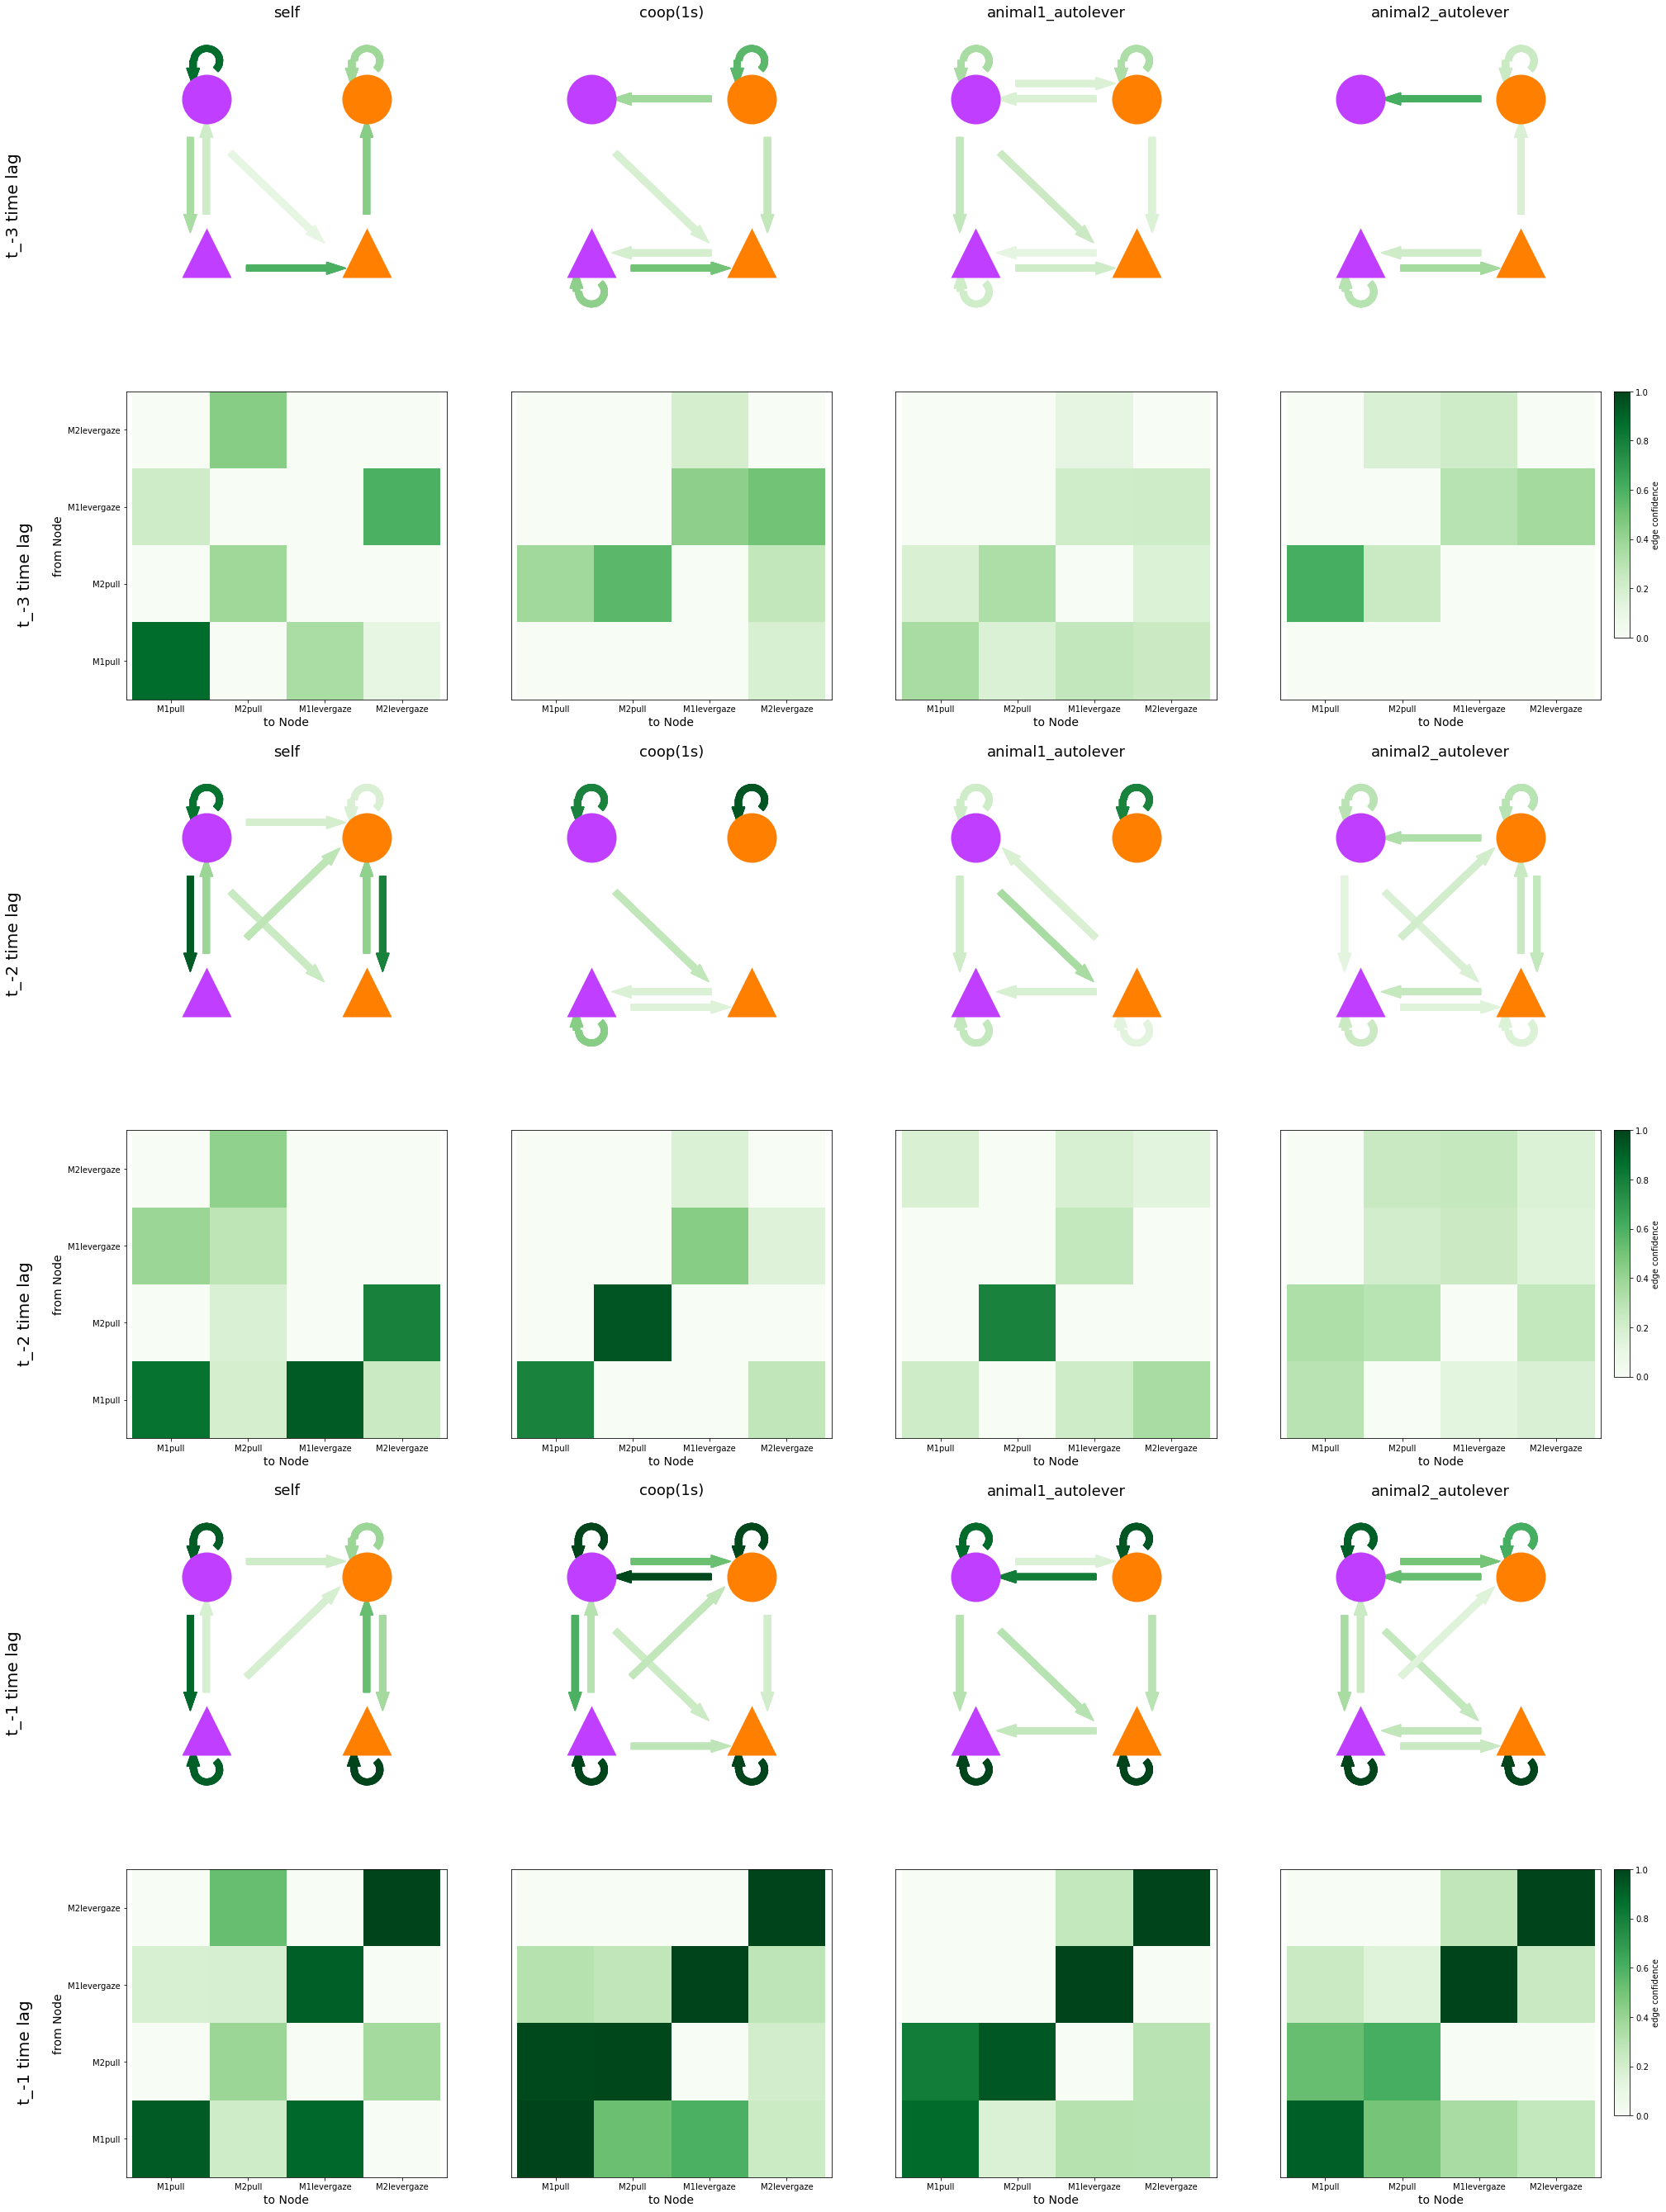

In [17]:
# ONLY FOR PLOT!! 
# define DBN related summarizing variables
DBN_group_typenames = ['self','coop(1s)','animal1_autolever','animal2_autolever']
DBN_group_typeIDs  =  [1,3,8,9]
DBN_group_coopthres = [0,1,1,1]
nDBN_groups = np.shape(DBN_group_typenames)[0]


# make sure these variables are the same as in the previous steps
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]
#
moreSampSize = 0
if moreSampSize:
    # different data (down/re)sampling numbers
    # samplingsizes = np.arange(1100,3000,100)
    samplingsizes = [1100]
    # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
    # samplingsizes = [100,500]
    # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
    samplingsizes_name = list(map(str, samplingsizes))
else:
    samplingsizes_name = ['min_row_number']   
nsamplings = np.shape(samplingsizes_name)[0]

# make sure these variables are consistent with the train_DBN_alec.py settings
# eventnames = ["pull1","pull2","gaze1","gaze2"]
eventnames = ["M1pull","M2pull","M1levergaze","M2levergaze"]
eventnode_locations = [[0,1],[1,1],[0,0],[1,0]]
eventname_locations = [[-0.5,1.0],[1.2,1],[-0.6,0],[1.2,0]]
# indicate where edge starts
# for the self edge, it's the center of the self loop
nodearrow_locations = [[[0.00,1.25],[0.25,1.10],[-.10,0.75],[0.15,0.65]],
                       [[0.75,1.00],[1.00,1.25],[0.85,0.65],[1.10,0.75]],
                       [[0.00,0.25],[0.25,0.35],[0.00,-.25],[0.25,-.10]],
                       [[0.75,0.35],[1.00,0.25],[0.75,0.00],[1.00,-.25]]]
# indicate where edge goes
# for the self edge, it's the theta1 and theta2 (with fixed radius)
nodearrow_directions = [[[ -45,-180],[0.50,0.00],[0.00,-.50],[0.50,-.50]],
                        [[-.50,0.00],[ -45,-180],[-.50,-.50],[0.00,-.50]],
                        [[0.00,0.50],[0.50,0.50],[ 180,  45],[0.50,0.00]],
                        [[-.50,0.50],[0.00,0.50],[-.50,0.00],[ 180,  45]]]

nevents = np.size(eventnames)
# eventnodes_color = ['b','r','y','g']
eventnodes_color = ['#BF3EFF','#FF7F00','#BF3EFF','#FF7F00']
eventnodes_shape = ["o","o","^","^"]
    

# different session conditions (aka DBN groups)
# different time lags (t_-3, t_-2 and t_-1)
fig, axs = plt.subplots(6,nDBN_groups)
fig.set_figheight(48)
fig.set_figwidth(8*nDBN_groups)

time_lags = ['t_-3','t_-2','t_-1']
fromRowIDs =[[0,1,2,3],[4,5,6,7],[8,9,10,11]]
ntime_lags = np.shape(time_lags)[0]

temp_resolu = temp_resolus[0]
j_sampsize_name = samplingsizes_name[0]    

data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
if not os.path.exists(data_saved_subfolder):
    os.makedirs(data_saved_subfolder)
if moreSampSize:
    with open(data_saved_subfolder+'/DAGscores_'+str(temp_resolu)+'TempRo_'+j_sampsize_name+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
        DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
    with open(data_saved_subfolder+'/DAGscores_shuffled_'+str(temp_resolu)+'TempRo_'+j_sampsize_name+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
        DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
    with open(data_saved_subfolder+'/weighted_graphs_'+str(temp_resolu)+'TempRo_'+j_sampsize_name+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
        weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
    with open(data_saved_subfolder+'/weighted_graphs_shuffled_'+str(temp_resolu)+'TempRo_'+j_sampsize_name+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
        weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
    with open(data_saved_subfolder+'/sig_edges_'+str(temp_resolu)+'TempRo_'+j_sampsize_name+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
        sig_edges_diffTempRo_diffSampSize = pickle.load(f)

else:
    with open(data_saved_subfolder+'/DAGscores_'+str(temp_resolu)+'TempRo_'+j_sampsize_name+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
    with open(data_saved_subfolder+'/DAGscores_shuffled_'+str(temp_resolu)+'TempRo_'+j_sampsize_name+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
    with open(data_saved_subfolder+'/weighted_graphs_'+str(temp_resolu)+'TempRo_'+j_sampsize_name+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
    with open(data_saved_subfolder+'/weighted_graphs_shuffled_'+str(temp_resolu)+'TempRo_'+j_sampsize_name+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
    with open(data_saved_subfolder+'/sig_edges_'+str(temp_resolu)+'TempRo_'+j_sampsize_name+'SampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        sig_edges_diffTempRo_diffSampSize = pickle.load(f)




for ilag in np.arange(0,ntime_lags,1):
    
    time_lag_name = time_lags[ilag]
    fromRowID = fromRowIDs[ilag]
    
    for iDBN_group in np.arange(0,nDBN_groups,1):

        try:

            iDBN_group_typename = DBN_group_typenames[iDBN_group]

            weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][iDBN_group_typename]
            weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][iDBN_group_typename]
            # sig_edges_tgt = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][iDBN_group_typename]
            sig_edges_tgt = get_significant_edges(weighted_graphs_tgt,weighted_graphs_shuffled_tgt)

            #sig_edges_tgt = sig_edges_tgt*((weighted_graphs_tgt.mean(axis=0)>0.5)*1)

            sig_avg_dags = weighted_graphs_tgt.mean(axis = 0) * sig_edges_tgt
            sig_avg_dags = sig_avg_dags[fromRowID,:]

            # plot
            axs[ilag*2+0,iDBN_group].set_title(iDBN_group_typename,fontsize=18)
            axs[ilag*2+0,iDBN_group].set_xlim([-0.5,1.5])
            axs[ilag*2+0,iDBN_group].set_ylim([-0.5,1.5])
            axs[ilag*2+0,iDBN_group].set_xticks([])
            axs[ilag*2+0,iDBN_group].set_xticklabels([])
            axs[ilag*2+0,iDBN_group].set_yticks([])
            axs[ilag*2+0,iDBN_group].set_yticklabels([])
            axs[ilag*2+0,iDBN_group].spines['top'].set_visible(False)
            axs[ilag*2+0,iDBN_group].spines['right'].set_visible(False)
            axs[ilag*2+0,iDBN_group].spines['bottom'].set_visible(False)
            axs[ilag*2+0,iDBN_group].spines['left'].set_visible(False)
            # axs[ilag*2+0,iDBN_group].axis('equal')


            for ieventnode in np.arange(0,nevents,1):
                # plot the event nodes
                axs[ilag*2+0,iDBN_group].plot(eventnode_locations[ieventnode][0],eventnode_locations[ieventnode][1],
                                              eventnodes_shape[ieventnode],markersize=60,markerfacecolor=eventnodes_color[ieventnode],
                                              markeredgecolor='none')              
                #axs[ilag*2+0,iDBN_group].text(eventname_locations[ieventnode][0],eventname_locations[ieventnode][1],
                #                       eventnames[ieventnode],fontsize=15)

                clmap = mpl.cm.get_cmap('Greens')

                # plot the event edges
                for ifromNode in np.arange(0,nevents,1):
                    for itoNode in np.arange(0,nevents,1):
                        edge_weight_tgt = sig_avg_dags[ifromNode,itoNode]
                        if edge_weight_tgt>0:
                            if not ifromNode == itoNode:
                                #axs[ilag*2+0,iDBN_group].plot(eventnode_locations[ifromNode],eventnode_locations[itoNode],'k-',linewidth=edge_weight_tgt*3)
                                axs[ilag*2+0,iDBN_group].arrow(nodearrow_locations[ifromNode][itoNode][0],
                                                        nodearrow_locations[ifromNode][itoNode][1],
                                                        nodearrow_directions[ifromNode][itoNode][0],
                                                        nodearrow_directions[ifromNode][itoNode][1],
                                                        # head_width=0.08*abs(edge_weight_tgt),
                                                        # width=0.04*abs(edge_weight_tgt),
                                                        head_width=0.08,
                                                        width=0.04,   
                                                        color = clmap(edge_weight_tgt))
                            if ifromNode == itoNode:
                                ring = mpatches.Wedge(nodearrow_locations[ifromNode][itoNode],
                                                      .1, nodearrow_directions[ifromNode][itoNode][0],
                                                      nodearrow_directions[ifromNode][itoNode][1], 
                                                      # 0.04*abs(edge_weight_tgt),
                                                      0.04,
                                                      color = clmap(edge_weight_tgt))
                                p = PatchCollection(
                                    [ring], 
                                    facecolor=clmap(edge_weight_tgt), 
                                    edgecolor=clmap(edge_weight_tgt)
                                )
                                axs[ilag*2+0,iDBN_group].add_collection(p)
                                # add arrow head
                                if ifromNode < 2:
                                    axs[ilag*2+0,iDBN_group].arrow(nodearrow_locations[ifromNode][itoNode][0]-0.1+0.02*edge_weight_tgt,
                                                            nodearrow_locations[ifromNode][itoNode][1],
                                                            0,-0.05,color=clmap(edge_weight_tgt),
                                                            # head_width=0.08*edge_weight_tgt,width=0.04*edge_weight_tgt
                                                            head_width=0.08,width=0.04      
                                                            )
                                else:
                                    axs[ilag*2+0,iDBN_group].arrow(nodearrow_locations[ifromNode][itoNode][0]-0.1+0.02*edge_weight_tgt,
                                                            nodearrow_locations[ifromNode][itoNode][1],
                                                            0,0.02,color=clmap(edge_weight_tgt),
                                                            # head_width=0.08*edge_weight_tgt,width=0.04*edge_weight_tgt
                                                            head_width=0.08,width=0.04      
                                                            )

            # heatmap for the weights
            sig_avg_dags_df = pd.DataFrame(sig_avg_dags)
            sig_avg_dags_df.columns = eventnames
            sig_avg_dags_df.index = eventnames
            vmin,vmax = 0,1

            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
            im = axs[ilag*2+1,iDBN_group].pcolormesh(sig_avg_dags_df,cmap="Greens",norm=norm)
            #
            if iDBN_group == nDBN_groups-1:
                cax = axs[ilag*2+1,iDBN_group].inset_axes([1.04, 0.2, 0.05, 0.8])
                fig.colorbar(im, ax=axs[ilag*2+1,iDBN_group], cax=cax,label='edge confidence')

            axs[ilag*2+1,iDBN_group].axis('equal')
            axs[ilag*2+1,iDBN_group].set_xlabel('to Node',fontsize=14)
            axs[ilag*2+1,iDBN_group].set_xticks(np.arange(0.5,4.5,1))
            axs[ilag*2+1,iDBN_group].set_xticklabels(eventnames)
            if iDBN_group == 0:
                axs[ilag*2+1,iDBN_group].set_ylabel('from Node',fontsize=14)
                axs[ilag*2+1,iDBN_group].set_yticks(np.arange(0.5,4.5,1))
                axs[ilag*2+1,iDBN_group].set_yticklabels(eventnames)
                axs[ilag*2+1,iDBN_group].text(-1.5,1,time_lag_name+' time lag',rotation=90,fontsize=20)
                axs[ilag*2+0,iDBN_group].text(-1.25,0,time_lag_name+' time lag',rotation=90,fontsize=20)
            else:
                axs[ilag*2+1,iDBN_group].set_yticks([])
                axs[ilag*2+1,iDBN_group].set_yticklabels([])

        except:
            continue
            
            
savefigs = 0
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents_autolever/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    if moreSampSize:
        plt.savefig(figsavefolder+"threeTimeLag_DAGs_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows.pdf')
    else:  
        plt.savefig(figsavefolder+"threeTimeLag_DAGs_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_'+j_sampsize_name+'.pdf')
            
            
            

## Plots that include all pairs 
### modulation index, use self condition as the base
#### show different task condition in one plot, and show 1s, 2s, 3s time lags or merged

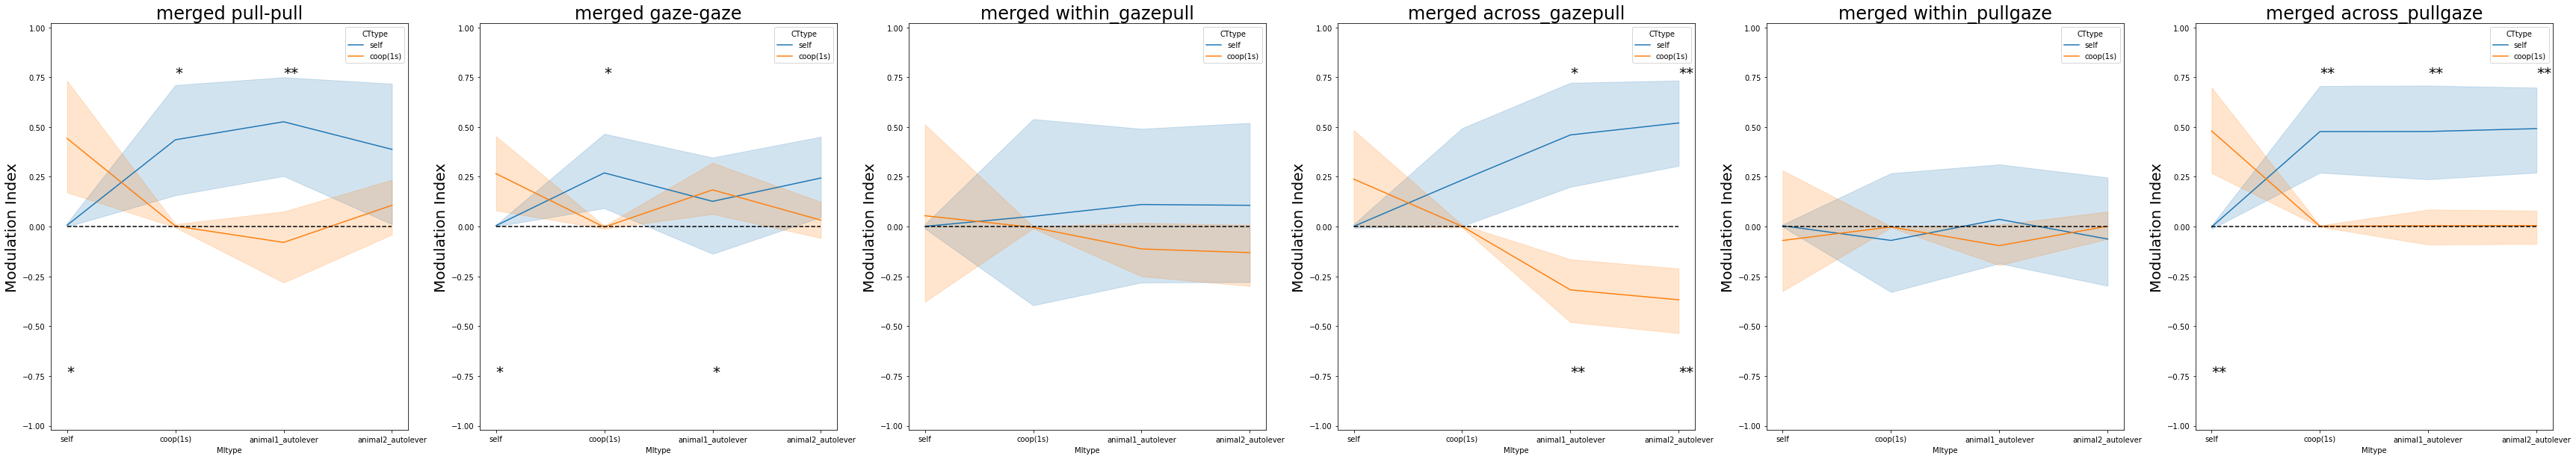

In [18]:
# PLOT multiple pairs in one plot, so need to load data seperately
moreSampSize = 0
#
animal1_fixedorders = ['eddie','dodson','dannon','ginger',]
animal2_fixedorders = ['sparkle','scorch','kanga','kanga',]
animal_pooled_list = ['E','SP','DO','SC','DA','KwDA','G','KwG',]

# dannon kanga did not have coop 3s data
# animal1_fixedorders = ['eddie','dodson','ginger','koala']
# animal2_fixedorders = ['sparkle','scorch','kanga','vermelho']
# animal_pooled_list = ['E','SP','DO','SC','G','KwG','KO','V']

nanimalpairs = np.shape(animal1_fixedorders)[0]
nanimalpooled = np.shape(animal_pooled_list)[0]

nMIbootstraps = 150

# timelags = [1,2,3] # 1 or 2 or 3 or 0(merged - merge all three lags) or 12 (merged lag 1 and 2)
timelags = [0]
# timelags = [12]
# timelagnames = ['1secondlag','2secondlag','3secondlag'] # '1/2/3second' or 'merged' or '12merged'
timelagnames = ['merged'] # together with timelag = 0
# timelagnames = ['12merged'] # together with timelag = 12
ntimelags_forplot = np.shape(timelags)[0]


MI_basetype = 'self' # 'self'; other options: 'coop(2s)', 'coop(1.5s)'
MI_comptypes = ['self','coop(1s)','animal1_autolever','animal2_autolever'] # coop(1s)'; other options: 'coop(2s)', 'coop(1.5s)'
# MI_comptypes = ['coop(3s)','coop(2s)'] # coop(1s)'; other options: 'coop(2s)', 'coop(1.5s)'
MI_conttype = 'coop(1s)' # 'no-vision'; other options: 'coop(2s)', 'coop(1.5s)'
nMI_comptypes = np.shape(MI_comptypes)[0]
#
# MI_comptypes_toplot = ['animal1_autolever','animal2_autolever'] 
MI_comptypes_toplot = MI_comptypes
nMI_comptypes_toplot = np.shape(MI_comptypes_toplot)[0]


# for plot
dependencynames = ['pull-pull','gaze-gaze','within_gazepull','across_gazepull','within_pullgaze','across_pullgaze']
dependencytargets = dependencynames
# dependencytargets = ['pull-pull','within_gazepull','across_pullgaze']
# dependencytargets = ['pull-pull','within_gazepull','across_pullgaze','pullgaze_merged']
ndeptargets = np.shape(dependencytargets)[0]
    
#
fig, axs = plt.subplots(ntimelags_forplot, ndeptargets)
fig.set_figheight(10*ntimelags_forplot)
fig.set_figwidth(10*ndeptargets)

#


#
for itimelag in np.arange(0,ntimelags_forplot,1):
    timelag = timelags[itimelag]
    timelagname = timelagnames[itimelag]
    
    MI_coop_self_all_IndiAni_pooled = dict.fromkeys(MI_comptypes,[])
    MI_nov_coop_all_IndiAni_pooled =  dict.fromkeys(MI_comptypes,[])
    MI_coop_self_mean_IndiAni_pooled =dict.fromkeys(MI_comptypes,[])
    MI_nov_coop_mean_IndiAni_pooled = dict.fromkeys(MI_comptypes,[])
    
    for iMI_comptype in np.arange(0,nMI_comptypes,1):
        MI_comptype = MI_comptypes[iMI_comptype]
        
        # 
        MI_coop_self_all_IndiAni = np.zeros([nanimalpairs*2,nMIbootstraps,6])
        MI_coop_self_mean_IndiAni = np.zeros([nanimalpairs*2,6])
        MI_nov_coop_all_IndiAni = np.zeros([nanimalpairs*2,nMIbootstraps,6])
        MI_nov_coop_mean_IndiAni = np.zeros([nanimalpairs*2,6])
        
        ntimelags = 1
        if timelag == 0:
            ntimelags = 3
            MI_coop_self_all_IndiAni = np.zeros([nanimalpairs*2,nMIbootstraps*3,6])
            MI_coop_self_mean_IndiAni = np.zeros([nanimalpairs*2,6])
            MI_nov_coop_all_IndiAni = np.zeros([nanimalpairs*2,nMIbootstraps*3,6])
            MI_nov_coop_mean_IndiAni = np.zeros([nanimalpairs*2,6])
        if timelag == 12:
            ntimelags = 2
            MI_coop_self_all_IndiAni = np.zeros([nanimalpairs*2,nMIbootstraps*2,6])
            MI_coop_self_mean_IndiAni = np.zeros([nanimalpairs*2,6])
            MI_nov_coop_all_IndiAni = np.zeros([nanimalpairs*2,nMIbootstraps*2,6])
            MI_nov_coop_mean_IndiAni = np.zeros([nanimalpairs*2,6])

            

        for ianimalpair in np.arange(0,nanimalpairs,1):
            animal1_fixedorder = animal1_fixedorders[ianimalpair]
            animal2_fixedorder = animal2_fixedorders[ianimalpair]
            
            # make sure these variables are the same as in the previous steps
            # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
            temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
            ntemp_reses = np.shape(temp_resolus)[0]
            #
            if moreSampSize:
                # different data (down/re)sampling numbers
                # samplingsizes = np.arange(1100,3000,100)
                samplingsizes = [1100]
                # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
                # samplingsizes = [100,500]
                # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
                samplingsizes_name = list(map(str, samplingsizes))
            else:
                samplingsizes_name = ['min_row_number']   
            nsamplings = np.shape(samplingsizes_name)[0]

            #
            temp_resolu = temp_resolus[0]
            j_sampsize_name = samplingsizes_name[0] 
            
            #
            data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
            #
            if moreSampSize:
                with open(data_saved_subfolder+'/weighted_graphs_'+str(temp_resolu)+'TempRo_'+j_sampsize_name+'SampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
                    weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
                with open(data_saved_subfolder+'/weighted_graphs_shuffled_'+str(temp_resolu)+'TempRo_'+j_sampsize_name+'SampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
                    weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
                with open(data_saved_subfolder+'/sig_edges_'+str(temp_resolu)+'TempRo_'+j_sampsize_name+'SampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
                    sig_edges_diffTempRo_diffSampSize = pickle.load(f)
            else:
                with open(data_saved_subfolder+'/weighted_graphs_'+str(temp_resolu)+'TempRo_'+j_sampsize_name+'SampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
                    weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
                with open(data_saved_subfolder+'/weighted_graphs_shuffled_'+str(temp_resolu)+'TempRo_'+j_sampsize_name+'SampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
                    weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
                with open(data_saved_subfolder+'/sig_edges_'+str(temp_resolu)+'TempRo_'+j_sampsize_name+'SampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
                    sig_edges_diffTempRo_diffSampSize = pickle.load(f)

               

            # load edge weight data    
            weighted_graphs_self = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][MI_basetype]
            weighted_graphs_sf_self = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][MI_basetype]
            sig_edges_self = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][MI_basetype]
            #
            weighted_graphs_coop = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][MI_comptype]
            weighted_graphs_sf_coop = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][MI_comptype]
            sig_edges_coop = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][MI_comptype]
            #
            weighted_graphs_nov = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][MI_conttype]
            weighted_graphs_sf_nov = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][MI_conttype]
            sig_edges_nov = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][MI_conttype]

            
            
            # organize the key edge data
            weighted_graphs_self_mean = weighted_graphs_self.mean(axis=0)
            weighted_graphs_coop_mean = weighted_graphs_coop.mean(axis=0)
            weighted_graphs_nov_mean = weighted_graphs_nov.mean(axis=0)
            # MI_coop_self = (weighted_graphs_coop_mean-weighted_graphs_self_mean)/(weighted_graphs_coop_mean+weighted_graphs_self_mean)
            # MI_nov_coop = (weighted_graphs_nov_mean-weighted_graphs_coop_mean)/(weighted_graphs_nov_mean+weighted_graphs_coop_mean)
            # MI_coop_self = ((weighted_graphs_coop-weighted_graphs_self)/(weighted_graphs_coop+weighted_graphs_self)).mean(axis=0)
            # MI_nov_coop = ((weighted_graphs_nov-weighted_graphs_coop)/(weighted_graphs_nov+weighted_graphs_coop)).mean(axis=0)
            #
            if 0:
                MI_coop_self_all = weighted_graphs_coop-weighted_graphs_self
                MI_nov_coop_all = weighted_graphs_nov-weighted_graphs_coop  
                MI_coop_self = (weighted_graphs_coop-weighted_graphs_self).mean(axis=0)
                MI_nov_coop = (weighted_graphs_nov-weighted_graphs_coop).mean(axis=0)
                #
                sig_edges_coop_self = ((sig_edges_coop+sig_edges_self)>0)*1
                sig_edges_nov_coop = ((sig_edges_coop+sig_edges_nov)>0)*1
                #
                MI_coop_self = MI_coop_self * sig_edges_coop_self
                MI_nov_coop = MI_nov_coop * sig_edges_nov_coop
                #
                nMIbootstraps = 1
            else:
                nMIbootstraps = 150
                #
                MI_coop_self_all,sig_edges_coop_self = Modulation_Index(weighted_graphs_self, weighted_graphs_coop,
                                                  sig_edges_self, sig_edges_coop, nMIbootstraps)
                # MI_coop_self_all = MI_coop_self_all * sig_edges_coop_self
                # MI_coop_self_all[MI_coop_self_all==0] = np.nan
                MI_coop_self = np.nanmean(MI_coop_self_all,axis = 0)
                # MI_coop_self = MI_coop_self * sig_edges_coop_self
                
                MI_nov_coop_all,sig_edges_nov_coop  = Modulation_Index(weighted_graphs_coop, weighted_graphs_nov,
                                                  sig_edges_coop, sig_edges_nov, nMIbootstraps)
                # MI_nov_coop_all = MI_nov_coop_all * sig_edges_nov_coop
                # MI_nov_coop_all[MI_nov_coop_all==0] = np.nan
                MI_nov_coop = np.nanmean(MI_nov_coop_all,axis = 0)
                # MI_nov_coop = MI_nov_coop * sig_edges_nov_coop
    
            #
            if timelag == 1:
                pull_pull_fromNodes_all = [9,8]
                pull_pull_toNodes_all = [0,1]
                #
                gaze_gaze_fromNodes_all = [11,10]
                gaze_gaze_toNodes_all = [2,3]
                #
                within_pullgaze_fromNodes_all = [8,9]
                within_pullgaze_toNodes_all = [2,3]
                #
                across_pullgaze_fromNodes_all = [9,8]
                across_pullgaze_toNodes_all = [2,3]
                #
                within_gazepull_fromNodes_all = [10,11]
                within_gazepull_toNodes_all = [0,1]
                #
                across_gazepull_fromNodes_all = [11,10]
                across_gazepull_toNodes_all = [0,1]
                #
                ntimelags = 1
                #
            elif timelag == 2:
                pull_pull_fromNodes_all = [5,4]
                pull_pull_toNodes_all = [0,1]
                #
                gaze_gaze_fromNodes_all = [7,6]
                gaze_gaze_toNodes_all = [2,3]
                #
                within_pullgaze_fromNodes_all = [4,5]
                within_pullgaze_toNodes_all = [2,3]
                #
                across_pullgaze_fromNodes_all = [5,4]
                across_pullgaze_toNodes_all = [2,3]
                #
                within_gazepull_fromNodes_all = [6,7]
                within_gazepull_toNodes_all = [0,1]
                #
                across_gazepull_fromNodes_all = [7,6]
                across_gazepull_toNodes_all = [0,1]
                #
                ntimelags = 1
                #
            elif timelag == 3:
                pull_pull_fromNodes_all = [1,0]
                pull_pull_toNodes_all = [0,1]
                #
                gaze_gaze_fromNodes_all = [3,2]
                gaze_gaze_toNodes_all = [2,3]
                #
                within_pullgaze_fromNodes_all = [0,1]
                within_pullgaze_toNodes_all = [2,3]
                #
                across_pullgaze_fromNodes_all = [1,0]
                across_pullgaze_toNodes_all = [2,3]
                #
                within_gazepull_fromNodes_all = [2,3]
                within_gazepull_toNodes_all = [0,1]
                #
                across_gazepull_fromNodes_all = [3,2]
                across_gazepull_toNodes_all = [0,1]
                #
                ntimelags = 1
                #
            elif timelag == 0:
                pull_pull_fromNodes_all = [[1,5,9],[0,4,8]]
                pull_pull_toNodes_all = [[0,0,0],[1,1,1]]
                #
                gaze_gaze_fromNodes_all = [[3,7,11],[2,6,10]]
                gaze_gaze_toNodes_all = [[2,2,2],[3,3,3]]
                #
                within_pullgaze_fromNodes_all = [[0,4,8],[1,5,9]]
                within_pullgaze_toNodes_all = [[2,2,2],[3,3,3]]
                #
                across_pullgaze_fromNodes_all = [[1,5,9],[0,4,8]]
                across_pullgaze_toNodes_all = [[2,2,2],[3,3,3]]
                #
                within_gazepull_fromNodes_all = [[2,6,10],[3,7,11]]
                within_gazepull_toNodes_all = [[0,0,0],[1,1,1]]
                #
                across_gazepull_fromNodes_all = [[3,7,11],[2,6,10]]
                across_gazepull_toNodes_all = [[0,0,0],[1,1,1]]
                #
                ntimelags = 3
                #
            elif timelag == 12:
                pull_pull_fromNodes_all = [[5,9],[4,8]]
                pull_pull_toNodes_all = [[0,0],[1,1]]
                #
                gaze_gaze_fromNodes_all = [[7,11],[6,10]]
                gaze_gaze_toNodes_all = [[2,2],[3,3]]
                #
                within_pullgaze_fromNodes_all = [[4,8],[5,9]]
                within_pullgaze_toNodes_all = [[2,2],[3,3]]
                #
                across_pullgaze_fromNodes_all = [[5,9],[4,8]]
                across_pullgaze_toNodes_all = [[2,2],[3,3]]
                #
                within_gazepull_fromNodes_all = [[6,10],[7,11]]
                within_gazepull_toNodes_all = [[0,0],[1,1]]
                #
                across_gazepull_fromNodes_all = [[7,11],[6,10]]
                across_gazepull_toNodes_all = [[0,0],[1,1]]
                #
                ntimelags = 2
                #
    
    
            for ianimal in np.arange(0,2,1):

                # coop self modulation
                # pull-pull
                a1 = MI_coop_self_all[:,pull_pull_fromNodes_all[ianimal],pull_pull_toNodes_all[ianimal]].flatten()
                xxx1 = np.nanmean(a1)
                MI_coop_self_all_IndiAni[2*ianimalpair+ianimal,:,0] = a1
                MI_coop_self_mean_IndiAni[2*ianimalpair+ianimal,0] = xxx1
                # gaze-gaze
                a2 = (MI_coop_self_all[:,gaze_gaze_fromNodes_all[ianimal],gaze_gaze_toNodes_all[ianimal]]).flatten()
                xxx2 = np.nanmean(a2)
                MI_coop_self_all_IndiAni[2*ianimalpair+ianimal,:,1] = a2
                MI_coop_self_mean_IndiAni[2*ianimalpair+ianimal,1] = xxx2
                # within animal gazepull
                a3 = (MI_coop_self_all[:,within_gazepull_fromNodes_all[ianimal],within_gazepull_toNodes_all[ianimal]]).flatten()
                xxx3 = np.nanmean(a3)
                MI_coop_self_all_IndiAni[2*ianimalpair+ianimal,:,2] = a3
                MI_coop_self_mean_IndiAni[2*ianimalpair+ianimal,2] = xxx3
                # across animal gazepull
                a4 = (MI_coop_self_all[:,across_gazepull_fromNodes_all[ianimal],across_gazepull_toNodes_all[ianimal]]).flatten()
                xxx4 = np.nanmean(a4)
                MI_coop_self_all_IndiAni[2*ianimalpair+ianimal,:,3] = a4
                MI_coop_self_mean_IndiAni[2*ianimalpair+ianimal,3] = xxx4
                # within animal pullgaze
                a5 = (MI_coop_self_all[:,within_pullgaze_fromNodes_all[ianimal],within_pullgaze_toNodes_all[ianimal]]).flatten()
                xxx5 = np.nanmean(a5)
                MI_coop_self_all_IndiAni[2*ianimalpair+ianimal,:,4] = a5
                MI_coop_self_mean_IndiAni[2*ianimalpair+ianimal,4] = xxx5
                # across animal pullgaze
                a6 = (MI_coop_self_all[:,across_pullgaze_fromNodes_all[ianimal],across_pullgaze_toNodes_all[ianimal]]).flatten()
                xxx6 = np.nanmean(a6)
                MI_coop_self_all_IndiAni[2*ianimalpair+ianimal,:,5] = a6
                MI_coop_self_mean_IndiAni[2*ianimalpair+ianimal,5] = xxx6


                # novision coop modulation
                # pull-pull
                a1 = MI_nov_coop_all[:,pull_pull_fromNodes_all[ianimal],pull_pull_toNodes_all[ianimal]].flatten()
                xxx1 = np.nanmean(a1)
                MI_nov_coop_all_IndiAni[2*ianimalpair+ianimal,:,0] = a1
                MI_nov_coop_mean_IndiAni[2*ianimalpair+ianimal,0] = xxx1
                # gaze-gaze
                a2 = (MI_nov_coop_all[:,gaze_gaze_fromNodes_all[ianimal],gaze_gaze_toNodes_all[ianimal]]).flatten()
                xxx2 = np.nanmean(a2)
                MI_nov_coop_all_IndiAni[2*ianimalpair+ianimal,:,1] = a2
                MI_nov_coop_mean_IndiAni[2*ianimalpair+ianimal,1] = xxx2
                # within animal gazepull
                a3 = (MI_nov_coop_all[:,within_gazepull_fromNodes_all[ianimal],within_gazepull_toNodes_all[ianimal]]).flatten()
                xxx3 = np.nanmean(a3)
                MI_nov_coop_all_IndiAni[2*ianimalpair+ianimal,:,2] = a3
                MI_nov_coop_mean_IndiAni[2*ianimalpair+ianimal,2] = xxx3
                # across animal gazepull
                a4 = (MI_nov_coop_all[:,across_gazepull_fromNodes_all[ianimal],across_gazepull_toNodes_all[ianimal]]).flatten()
                xxx4 = np.nanmean(a4)
                MI_nov_coop_all_IndiAni[2*ianimalpair+ianimal,:,3] = a4
                MI_nov_coop_mean_IndiAni[2*ianimalpair+ianimal,3] = xxx4
                # within animal pullgaze
                a5 = (MI_nov_coop_all[:,within_pullgaze_fromNodes_all[ianimal],within_pullgaze_toNodes_all[ianimal]]).flatten()
                xxx5 = np.nanmean(a5)
                MI_nov_coop_all_IndiAni[2*ianimalpair+ianimal,:,4] = a5
                MI_nov_coop_mean_IndiAni[2*ianimalpair+ianimal,4] = xxx5
                # across animal pullgaze
                a6 = (MI_nov_coop_all[:,across_pullgaze_fromNodes_all[ianimal],across_pullgaze_toNodes_all[ianimal]]).flatten()
                xxx6 = np.nanmean(a6)
                MI_nov_coop_all_IndiAni[2*ianimalpair+ianimal,:,5] = a6
                MI_nov_coop_mean_IndiAni[2*ianimalpair+ianimal,5] = xxx6


        # prepare the data
        # average all animals for each dependency
        MI_coop_self_all_IndiAni_all = MI_coop_self_all_IndiAni.reshape(nanimalpooled*nMIbootstraps*ntimelags,6)
        MI_nov_coop_all_IndiAni_all = MI_nov_coop_all_IndiAni.reshape(nanimalpooled*nMIbootstraps*ntimelags,6)
        MI_coop_self_all_IndiAni_allmean = np.nanmean(MI_coop_self_all_IndiAni_all,axis=0)
        MI_nov_coop_all_IndiAni_allmean = np.nanmean(MI_nov_coop_all_IndiAni_all,axis=0) 
        MI_coop_self_all_IndiAni_allse = np.nanstd(MI_coop_self_all_IndiAni_all,axis=0)/np.sqrt(nanimalpooled*nMIbootstraps*ntimelags) 
        MI_nov_coop_all_IndiAni_allse = np.nanstd(MI_nov_coop_all_IndiAni_all,axis=0)/np.sqrt(nanimalpooled*nMIbootstraps*ntimelags) 


        # pool everything together
        MI_coop_self_all_IndiAni_pooled[MI_comptype] = MI_coop_self_all_IndiAni_all
        MI_nov_coop_all_IndiAni_pooled[MI_comptype] = MI_nov_coop_all_IndiAni_all
        MI_coop_self_mean_IndiAni_pooled[MI_comptype] = MI_coop_self_mean_IndiAni
        MI_nov_coop_mean_IndiAni_pooled[MI_comptype] = MI_nov_coop_mean_IndiAni
    

    

    # plot 

    # all bootstraps
    # self
    MI_coop_self_all_IndiAni_self_df = pd.DataFrame(MI_coop_self_all_IndiAni_pooled['self'])
    MI_coop_self_all_IndiAni_self_df.columns = dependencynames
    MI_coop_self_all_IndiAni_self_df['MItype'] = 'self'
    MI_coop_self_all_IndiAni_self_df['CTtype'] = MI_basetype
    MI_coop_self_all_IndiAni_self_df['pullgaze_merged'] = (MI_coop_self_all_IndiAni_self_df['within_gazepull']+MI_coop_self_all_IndiAni_self_df['across_pullgaze'])/2
    #
    MI_nov_coop_all_IndiAni_self_df = pd.DataFrame(MI_nov_coop_all_IndiAni_pooled['self'])
    MI_nov_coop_all_IndiAni_self_df.columns = dependencynames
    MI_nov_coop_all_IndiAni_self_df['MItype'] = 'self'
    MI_nov_coop_all_IndiAni_self_df['CTtype'] = MI_conttype
    MI_nov_coop_all_IndiAni_self_df['pullgaze_merged'] = (MI_nov_coop_all_IndiAni_self_df['within_gazepull']+MI_nov_coop_all_IndiAni_self_df['across_pullgaze'])/2
    
    # coop (1s)
    MI_coop_self_all_IndiAni_MC1s_df = pd.DataFrame(MI_coop_self_all_IndiAni_pooled['coop(1s)'])
    MI_coop_self_all_IndiAni_MC1s_df.columns = dependencynames
    MI_coop_self_all_IndiAni_MC1s_df['MItype'] = 'coop(1s)'
    MI_coop_self_all_IndiAni_MC1s_df['CTtype'] = MI_basetype
    MI_coop_self_all_IndiAni_MC1s_df['pullgaze_merged'] = (MI_coop_self_all_IndiAni_MC1s_df['within_gazepull']+MI_coop_self_all_IndiAni_MC1s_df['across_pullgaze'])/2
    #
    MI_nov_coop_all_IndiAni_MC1s_df = pd.DataFrame(MI_nov_coop_all_IndiAni_pooled['coop(1s)'])
    MI_nov_coop_all_IndiAni_MC1s_df.columns = dependencynames
    MI_nov_coop_all_IndiAni_MC1s_df['MItype'] = 'coop(1s)'
    MI_nov_coop_all_IndiAni_MC1s_df['CTtype'] = MI_conttype
    MI_nov_coop_all_IndiAni_MC1s_df['pullgaze_merged'] = (MI_nov_coop_all_IndiAni_MC1s_df['within_gazepull']+MI_nov_coop_all_IndiAni_MC1s_df['across_pullgaze'])/2
    
    # animal1 auto lever
    MI_coop_self_all_IndiAni_A1AL_df = pd.DataFrame(MI_coop_self_all_IndiAni_pooled['animal1_autolever'])
    MI_coop_self_all_IndiAni_A1AL_df.columns = dependencynames
    MI_coop_self_all_IndiAni_A1AL_df['MItype'] = 'animal1_autolever'
    MI_coop_self_all_IndiAni_A1AL_df['CTtype'] = MI_basetype
    MI_coop_self_all_IndiAni_A1AL_df['pullgaze_merged'] = (MI_coop_self_all_IndiAni_A1AL_df['within_gazepull']+MI_coop_self_all_IndiAni_A1AL_df['across_pullgaze'])/2
    #
    MI_nov_coop_all_IndiAni_A1AL_df = pd.DataFrame(MI_nov_coop_all_IndiAni_pooled['animal1_autolever'])
    MI_nov_coop_all_IndiAni_A1AL_df.columns = dependencynames
    MI_nov_coop_all_IndiAni_A1AL_df['MItype'] = 'animal1_autolever'
    MI_nov_coop_all_IndiAni_A1AL_df['CTtype'] = MI_conttype
    MI_nov_coop_all_IndiAni_A1AL_df['pullgaze_merged'] = (MI_nov_coop_all_IndiAni_A1AL_df['within_gazepull']+MI_nov_coop_all_IndiAni_A1AL_df['across_pullgaze'])/2

    # animal2 auto lever
    MI_coop_self_all_IndiAni_A2AL_df = pd.DataFrame(MI_coop_self_all_IndiAni_pooled['animal2_autolever'])
    MI_coop_self_all_IndiAni_A2AL_df.columns = dependencynames
    MI_coop_self_all_IndiAni_A2AL_df['MItype'] = 'animal2_autolever'
    MI_coop_self_all_IndiAni_A2AL_df['CTtype'] = MI_basetype
    MI_coop_self_all_IndiAni_A2AL_df['pullgaze_merged'] = (MI_coop_self_all_IndiAni_A2AL_df['within_gazepull']+MI_coop_self_all_IndiAni_A2AL_df['across_pullgaze'])/2
    #
    MI_nov_coop_all_IndiAni_A2AL_df = pd.DataFrame(MI_nov_coop_all_IndiAni_pooled['animal2_autolever'])
    MI_nov_coop_all_IndiAni_A2AL_df.columns = dependencynames
    MI_nov_coop_all_IndiAni_A2AL_df['MItype'] = 'animal2_autolever'
    MI_nov_coop_all_IndiAni_A2AL_df['CTtype'] = MI_conttype
    MI_nov_coop_all_IndiAni_A2AL_df['pullgaze_merged'] = (MI_nov_coop_all_IndiAni_A2AL_df['within_gazepull']+MI_nov_coop_all_IndiAni_A2AL_df['across_pullgaze'])/2

    #
    df_long_bt =pd.concat([MI_coop_self_all_IndiAni_self_df,MI_nov_coop_all_IndiAni_self_df,
                           MI_coop_self_all_IndiAni_MC1s_df,MI_nov_coop_all_IndiAni_MC1s_df,
                           MI_coop_self_all_IndiAni_A1AL_df,MI_nov_coop_all_IndiAni_A1AL_df,
                           MI_coop_self_all_IndiAni_A2AL_df,MI_nov_coop_all_IndiAni_A2AL_df,])
    # df_long_bt =pd.concat([MI_coop_self_all_IndiAni_A1AL_df,MI_nov_coop_all_IndiAni_A1AL_df,
    #                        MI_coop_self_all_IndiAni_A2AL_df,MI_nov_coop_all_IndiAni_A2AL_df,])
    df_long2_bt = df_long_bt.melt(id_vars=['MItype','CTtype'], value_vars=dependencytargets,
                                  var_name='condition', value_name='value')

    #
    # average for each animal individuals
    # self
    MI_coop_self_mean_IndiAni_self_df = pd.DataFrame(MI_coop_self_mean_IndiAni_pooled['self'])
    MI_coop_self_mean_IndiAni_self_df.columns = dependencynames
    MI_coop_self_mean_IndiAni_self_df['MItype'] = 'self'
    MI_coop_self_mean_IndiAni_self_df['CTtype'] = MI_basetype
    MI_coop_self_mean_IndiAni_self_df['pullgaze_merged'] = (MI_coop_self_mean_IndiAni_self_df['within_gazepull']+MI_coop_self_mean_IndiAni_self_df['across_pullgaze'])/2
    #
    MI_nov_coop_mean_IndiAni_self_df = pd.DataFrame(MI_nov_coop_mean_IndiAni_pooled['self'])
    MI_nov_coop_mean_IndiAni_self_df.columns = dependencynames
    MI_nov_coop_mean_IndiAni_self_df['MItype'] = 'self'
    MI_nov_coop_mean_IndiAni_self_df['CTtype'] = MI_conttype
    MI_nov_coop_mean_IndiAni_self_df['pullgaze_merged'] = (MI_nov_coop_mean_IndiAni_self_df['within_gazepull']+MI_nov_coop_mean_IndiAni_self_df['across_pullgaze'])/2
    
    # coop (1s)
    MI_coop_self_mean_IndiAni_MC1s_df = pd.DataFrame(MI_coop_self_mean_IndiAni_pooled['coop(1s)'])
    MI_coop_self_mean_IndiAni_MC1s_df.columns = dependencynames
    MI_coop_self_mean_IndiAni_MC1s_df['MItype'] = 'coop(1s)'
    MI_coop_self_mean_IndiAni_MC1s_df['CTtype'] = MI_basetype
    MI_coop_self_mean_IndiAni_MC1s_df['pullgaze_merged'] = (MI_coop_self_mean_IndiAni_MC1s_df['within_gazepull']+MI_coop_self_mean_IndiAni_MC1s_df['across_pullgaze'])/2
    #
    MI_nov_coop_mean_IndiAni_MC1s_df = pd.DataFrame(MI_nov_coop_mean_IndiAni_pooled['coop(1s)'])
    MI_nov_coop_mean_IndiAni_MC1s_df.columns = dependencynames
    MI_nov_coop_mean_IndiAni_MC1s_df['MItype'] = 'coop(1s)'
    MI_nov_coop_mean_IndiAni_MC1s_df['CTtype'] = MI_conttype
    MI_nov_coop_mean_IndiAni_MC1s_df['pullgaze_merged'] = (MI_nov_coop_mean_IndiAni_MC1s_df['within_gazepull']+MI_nov_coop_mean_IndiAni_MC1s_df['across_pullgaze'])/2

    # animal1 auto lever
    MI_coop_self_mean_IndiAni_A1AL_df = pd.DataFrame(MI_coop_self_mean_IndiAni_pooled['animal1_autolever'])
    MI_coop_self_mean_IndiAni_A1AL_df.columns = dependencynames
    MI_coop_self_mean_IndiAni_A1AL_df['MItype'] = 'animal1_autolever'
    MI_coop_self_mean_IndiAni_A1AL_df['CTtype'] = MI_basetype
    MI_coop_self_mean_IndiAni_A1AL_df['pullgaze_merged'] = (MI_coop_self_mean_IndiAni_A1AL_df['within_gazepull']+MI_coop_self_mean_IndiAni_A1AL_df['across_pullgaze'])/2
    #
    MI_nov_coop_mean_IndiAni_A1AL_df = pd.DataFrame(MI_nov_coop_mean_IndiAni_pooled['animal1_autolever'])
    MI_nov_coop_mean_IndiAni_A1AL_df.columns = dependencynames
    MI_nov_coop_mean_IndiAni_A1AL_df['MItype'] = 'animal1_autolever'
    MI_nov_coop_mean_IndiAni_A1AL_df['CTtype'] = MI_conttype
    MI_nov_coop_mean_IndiAni_A1AL_df['pullgaze_merged'] = (MI_nov_coop_mean_IndiAni_A1AL_df['within_gazepull']+MI_nov_coop_mean_IndiAni_A1AL_df['across_pullgaze'])/2

    # animal2 auto lever
    MI_coop_self_mean_IndiAni_A2AL_df = pd.DataFrame(MI_coop_self_mean_IndiAni_pooled['animal2_autolever'])
    MI_coop_self_mean_IndiAni_A2AL_df.columns = dependencynames
    MI_coop_self_mean_IndiAni_A2AL_df['MItype'] = 'animal2_autolever'
    MI_coop_self_mean_IndiAni_A2AL_df['CTtype'] = MI_basetype
    MI_coop_self_mean_IndiAni_A2AL_df['pullgaze_merged'] = (MI_coop_self_mean_IndiAni_A2AL_df['within_gazepull']+MI_coop_self_mean_IndiAni_A2AL_df['across_pullgaze'])/2
    #
    MI_nov_coop_mean_IndiAni_A2AL_df = pd.DataFrame(MI_nov_coop_mean_IndiAni_pooled['animal2_autolever'])
    MI_nov_coop_mean_IndiAni_A2AL_df.columns = dependencynames
    MI_nov_coop_mean_IndiAni_A2AL_df['MItype'] = 'animal2_autolever'
    MI_nov_coop_mean_IndiAni_A2AL_df['CTtype'] = MI_conttype
    MI_nov_coop_mean_IndiAni_A2AL_df['pullgaze_merged'] = (MI_nov_coop_mean_IndiAni_A2AL_df['within_gazepull']+MI_nov_coop_mean_IndiAni_A2AL_df['across_pullgaze'])/2

    #
    df_long =pd.concat([MI_coop_self_mean_IndiAni_self_df,MI_nov_coop_mean_IndiAni_self_df,
                        MI_coop_self_mean_IndiAni_MC1s_df,MI_nov_coop_mean_IndiAni_MC1s_df,
                        MI_coop_self_mean_IndiAni_A1AL_df,MI_nov_coop_mean_IndiAni_A1AL_df,
                        MI_coop_self_mean_IndiAni_A2AL_df,MI_nov_coop_mean_IndiAni_A2AL_df,])
    # df_long =pd.concat([MI_coop_self_mean_IndiAni_A1AL_df,MI_nov_coop_mean_IndiAni_A1AL_df,
    #                     MI_coop_self_mean_IndiAni_A2AL_df,MI_nov_coop_mean_IndiAni_A2AL_df,])
    df_long2 = df_long.melt(id_vars=['MItype','CTtype'], value_vars=dependencytargets,
                        var_name='condition', value_name='value')
    
    # for plot
    for idep in np.arange(0,ndeptargets,1):
        ind = df_long2.condition==dependencytargets[idep]
        # ind = df_long2_bt.condition==dependencytargets[idep]
        #
        if ntimelags_forplot == 1:
            seaborn.lineplot(ax=axs[idep],data=df_long2[ind],x='MItype',y='value',hue='CTtype')
            # seaborn.lineplot(ax=axs[idep],data=df_long2_bt[ind],x='MItype',y='value',hue='CTtype')
            axs[idep].plot([0,3],[0,0],'k--')
            axs[idep].set_ylabel('Modulation Index',fontsize=20)
            axs[idep].set_title(timelagname+' '+dependencytargets[idep],fontsize=24)
            axs[idep].set_ylim([-1.02,1.02])
            #
            # add statistics
            CTtypes = [MI_basetype,MI_conttype]
            CTtype_plotlocs = [.75,-.75]
            nCTtypes = np.shape(CTtypes)[0]
            for iMItype in np.arange(0,nMI_comptypes_toplot,1):
                MItype_totest = MI_comptypes_toplot[iMItype]
                #
                for iCTtype in np.arange(0,nCTtypes,1):
                    CTtype_totest = CTtypes[iCTtype]
                    # 
                    ind_totest = (df_long2['condition']==dependencytargets[idep])&(df_long2['MItype']==MItype_totest)&(df_long2['CTtype']==CTtype_totest)
                    data_totest = np.array(df_long2[ind_totest]['value'])
                    pp = st.ttest_1samp(data_totest[~np.isnan(data_totest)],0).pvalue
                    # pp = st.wilcoxon(data_totest[~np.isnan(data_totest)]).pvalue
                    # 
                    if pp<=0.001:
                        axs[idep].text(iMItype,CTtype_plotlocs[iCTtype],'***',fontsize=20)
                    elif pp<=0.01:
                        axs[idep].text(iMItype,CTtype_plotlocs[iCTtype],'**',fontsize=20)
                    elif pp<=0.05:
                        axs[idep].text(iMItype,CTtype_plotlocs[iCTtype],'*',fontsize=20)
                    
                    
        else:
            seaborn.lineplot(ax=axs[itimelag,idep],data=df_long2[ind],x='MItype',y='value',hue='CTtype')
            # seaborn.lineplot(ax=axs[itimelag,idep],data=df_long2_bt[ind],x='MItype',y='value',hue='CTtype')
            axs[itimelag,idep].plot([0,3],[0,0],'k--')
            axs[itimelag,idep].set_ylabel('Modulation Index',fontsize=20)
            axs[itimelag,idep].set_title(timelagname+' '+dependencytargets[idep],fontsize=24)
            axs[itimelag,idep].set_ylim([-1.02,1.02])
            #
            # add statistics
            CTtypes = [MI_basetype,MI_conttype]
            CTtype_plotlocs = [.75,-.75]
            nCTtypes = np.shape(CTtypes)[0]
            for iMItype in np.arange(0,nMI_comptypes_toplot,1):
                MItype_totest = MI_comptypes_toplot[iMItype]
                #
                for iCTtype in np.arange(0,nCTtypes,1):
                    CTtype_totest = CTtypes[iCTtype]
                    # 
                    ind_totest = (df_long2['condition']==dependencytargets[idep])&(df_long2['MItype']==MItype_totest)&(df_long2['CTtype']==CTtype_totest)
                    data_totest = np.array(df_long2[ind_totest]['value'])
                    pp = st.ttest_1samp(data_totest[~np.isnan(data_totest)],0).pvalue
                    # pp = st.wilcoxon(data_totest[~np.isnan(data_totest)]).pvalue
                    # 
                    if pp<=0.001:
                        axs[itimelag,idep].text(iMItype,CTtype_plotlocs[iCTtype],'***',fontsize=20)
                    elif pp<=0.01:
                        axs[itimelag,idep].text(iMItype,CTtype_plotlocs[iCTtype],'**',fontsize=20)
                    elif pp<=0.05:
                        axs[itimelag,idep].text(iMItype,CTtype_plotlocs[iCTtype],'*',fontsize=20)
        

savefig = 1
if savefig:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents_autolever/'+savefile_sufix+'/'+cameraID+'/'
    if moreSampSize:
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_'+timelagname+'Lag_IndiAnimal_summarized_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows_subset_basedonToNodes_multiTimeLag_multiCoopsOnePanel.pdf')
    else:
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_'+timelagname+'Lag_IndiAnimal_summarized_'+str(temp_resolu)+'_'+j_sampsize_name+'_subset_basedonToNodes_multiTimeLag_multiCoopsOnePanel.pdf')
           
    


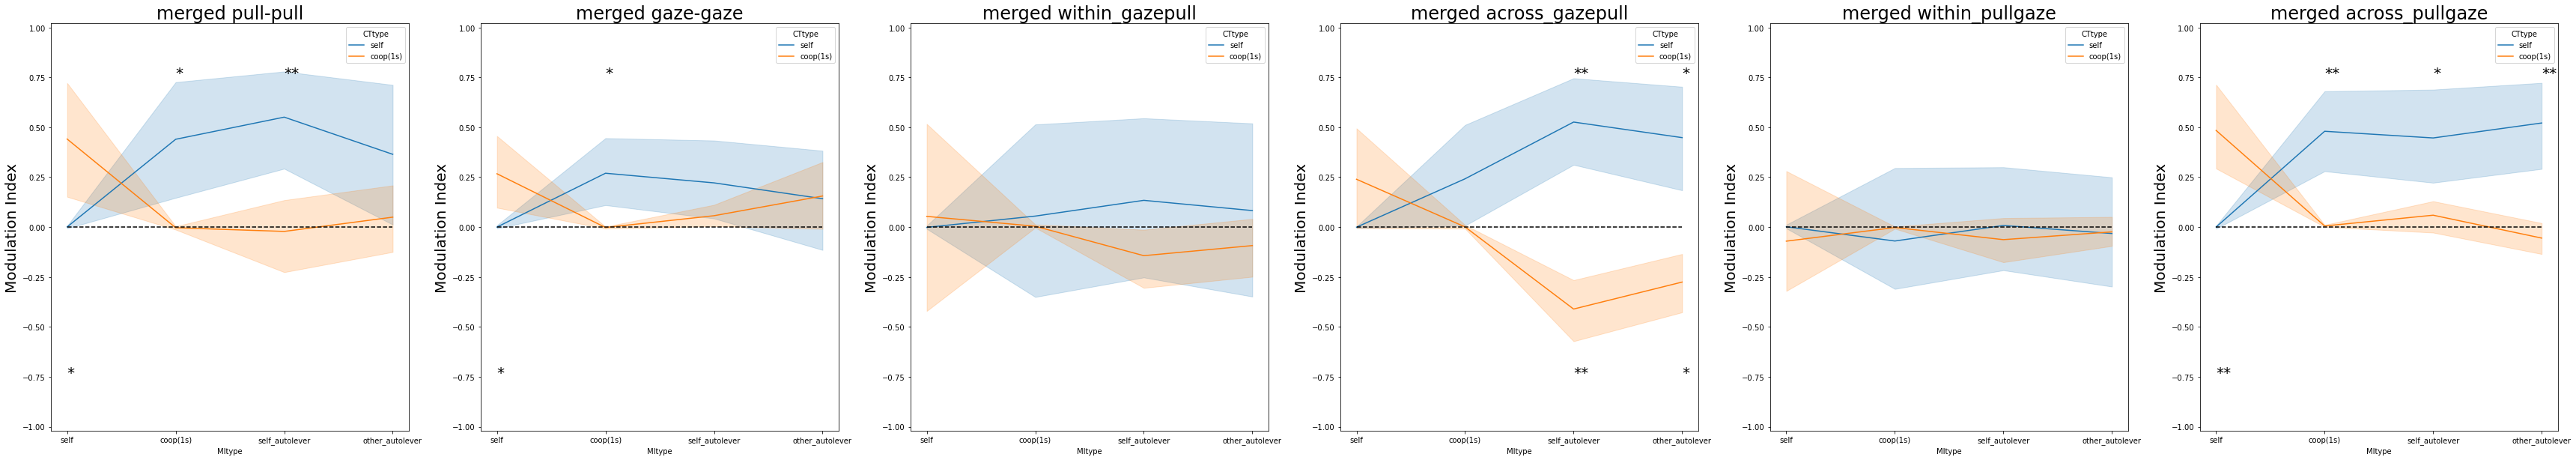

In [19]:
# PLOT multiple pairs in one plot, so need to load data seperately
moreSampSize = 0
#
animal1_fixedorders = ['eddie','dodson','dannon','ginger',]
animal2_fixedorders = ['sparkle','scorch','kanga','kanga',]
animal_pooled_list = ['E','SP','DO','SC','DA','KwDA','G','KwG',]

# dannon kanga did not have coop 3s data
# animal1_fixedorders = ['eddie','dodson','ginger','koala']
# animal2_fixedorders = ['sparkle','scorch','kanga','vermelho']
# animal_pooled_list = ['E','SP','DO','SC','G','KwG','KO','V']

nanimalpairs = np.shape(animal1_fixedorders)[0]
nanimalpooled = np.shape(animal_pooled_list)[0]

nMIbootstraps = 150

# timelags = [1,2,3] # 1 or 2 or 3 or 0(merged - merge all three lags) or 12 (merged lag 1 and 2)
timelags = [0]
# timelags = [12]
# timelagnames = ['1secondlag','2secondlag','3secondlag'] # '1/2/3second' or 'merged' or '12merged'
timelagnames = ['merged'] # together with timelag = 0
# timelagnames = ['12merged'] # together with timelag = 12
ntimelags_forplot = np.shape(timelags)[0]


MI_basetype = 'self' # 'self'; other options: 'coop(2s)', 'coop(1.5s)'
# MI_comptypes = ['self','coop(1s)','animal1_autolever','animal2_autolever'] # coop(1s)'; other options: 'coop(2s)', 'coop(1.5s)'
MI_comptypes = ['self','coop(1s)','self_autolever','other_autolever']
# MI_comptypes = ['coop(3s)','coop(2s)'] # coop(1s)'; other options: 'coop(2s)', 'coop(1.5s)'
MI_conttype = 'coop(1s)' # 'no-vision'; other options: 'coop(2s)', 'coop(1.5s)'
nMI_comptypes = np.shape(MI_comptypes)[0]
#
# MI_comptypes_toplot = ['animal1_autolever','animal2_autolever'] 
MI_comptypes_toplot = MI_comptypes
nMI_comptypes_toplot = np.shape(MI_comptypes_toplot)[0]


# for plot
dependencynames = ['pull-pull','gaze-gaze','within_gazepull','across_gazepull','within_pullgaze','across_pullgaze']
dependencytargets = dependencynames
# dependencytargets = ['pull-pull','within_gazepull','across_pullgaze']
# dependencytargets = ['pull-pull','within_gazepull','across_pullgaze','pullgaze_merged']
ndeptargets = np.shape(dependencytargets)[0]
    
#
fig, axs = plt.subplots(ntimelags_forplot, ndeptargets)
fig.set_figheight(10*ntimelags_forplot)
fig.set_figwidth(10*ndeptargets)

#


#
for itimelag in np.arange(0,ntimelags_forplot,1):
    timelag = timelags[itimelag]
    timelagname = timelagnames[itimelag]
    
    MI_coop_self_all_IndiAni_pooled = dict.fromkeys(MI_comptypes,[])
    MI_nov_coop_all_IndiAni_pooled =  dict.fromkeys(MI_comptypes,[])
    MI_coop_self_mean_IndiAni_pooled =dict.fromkeys(MI_comptypes,[])
    MI_nov_coop_mean_IndiAni_pooled = dict.fromkeys(MI_comptypes,[])
    
    for iMI_comptype in np.arange(0,nMI_comptypes,1):
        MI_comptype = MI_comptypes[iMI_comptype]
        
        # 
        MI_coop_self_all_IndiAni = np.zeros([nanimalpairs*2,nMIbootstraps,6])
        MI_coop_self_mean_IndiAni = np.zeros([nanimalpairs*2,6])
        MI_nov_coop_all_IndiAni = np.zeros([nanimalpairs*2,nMIbootstraps,6])
        MI_nov_coop_mean_IndiAni = np.zeros([nanimalpairs*2,6])
        
        ntimelags = 1
        if timelag == 0:
            ntimelags = 3
            MI_coop_self_all_IndiAni = np.zeros([nanimalpairs*2,nMIbootstraps*3,6])
            MI_coop_self_mean_IndiAni = np.zeros([nanimalpairs*2,6])
            MI_nov_coop_all_IndiAni = np.zeros([nanimalpairs*2,nMIbootstraps*3,6])
            MI_nov_coop_mean_IndiAni = np.zeros([nanimalpairs*2,6])
        if timelag == 12:
            ntimelags = 2
            MI_coop_self_all_IndiAni = np.zeros([nanimalpairs*2,nMIbootstraps*2,6])
            MI_coop_self_mean_IndiAni = np.zeros([nanimalpairs*2,6])
            MI_nov_coop_all_IndiAni = np.zeros([nanimalpairs*2,nMIbootstraps*2,6])
            MI_nov_coop_mean_IndiAni = np.zeros([nanimalpairs*2,6])

            

        for ianimalpair in np.arange(0,nanimalpairs,1):
            animal1_fixedorder = animal1_fixedorders[ianimalpair]
            animal2_fixedorder = animal2_fixedorders[ianimalpair]
            
            # make sure these variables are the same as in the previous steps
            # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
            temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
            ntemp_reses = np.shape(temp_resolus)[0]
            #
            if moreSampSize:
                # different data (down/re)sampling numbers
                # samplingsizes = np.arange(1100,3000,100)
                samplingsizes = [1100]
                # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
                # samplingsizes = [100,500]
                # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
                samplingsizes_name = list(map(str, samplingsizes))
            else:
                samplingsizes_name = ['min_row_number']   
            nsamplings = np.shape(samplingsizes_name)[0]

            #
            temp_resolu = temp_resolus[0]
            j_sampsize_name = samplingsizes_name[0] 
            
            # work on individual separately in a dyads
            for ianimal in np.arange(0,2,1):
                
                if MI_comptype == 'self_autolever':
                    if ianimal == 0:
                        MI_comptype_real = 'animal1_autolever'
                    elif ianimal == 1:
                        MI_comptype_real = 'animal2_autolever'
                elif MI_comptype == 'other_autolever':
                    if ianimal == 0:
                        MI_comptype_real = 'animal2_autolever'
                    elif ianimal == 1:
                        MI_comptype_real = 'animal1_autolever'
                else:
                    MI_comptype_real = MI_comptype
                
                #
                data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
                #
                if moreSampSize:
                    with open(data_saved_subfolder+'/weighted_graphs_'+str(temp_resolu)+'TempRo_'+j_sampsize_name+'SampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
                        weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
                    with open(data_saved_subfolder+'/weighted_graphs_shuffled_'+str(temp_resolu)+'TempRo_'+j_sampsize_name+'SampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
                        weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
                    with open(data_saved_subfolder+'/sig_edges_'+str(temp_resolu)+'TempRo_'+j_sampsize_name+'SampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
                        sig_edges_diffTempRo_diffSampSize = pickle.load(f)
                else:
                    with open(data_saved_subfolder+'/weighted_graphs_'+str(temp_resolu)+'TempRo_'+j_sampsize_name+'SampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
                        weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
                    with open(data_saved_subfolder+'/weighted_graphs_shuffled_'+str(temp_resolu)+'TempRo_'+j_sampsize_name+'SampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
                        weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
                    with open(data_saved_subfolder+'/sig_edges_'+str(temp_resolu)+'TempRo_'+j_sampsize_name+'SampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
                        sig_edges_diffTempRo_diffSampSize = pickle.load(f)



                # load edge weight data    
                weighted_graphs_self = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][MI_basetype]
                weighted_graphs_sf_self = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][MI_basetype]
                sig_edges_self = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][MI_basetype]
                #
                weighted_graphs_coop = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][MI_comptype_real]
                weighted_graphs_sf_coop = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][MI_comptype_real]
                sig_edges_coop = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][MI_comptype_real]
                #
                weighted_graphs_nov = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][MI_conttype]
                weighted_graphs_sf_nov = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][MI_conttype]
                sig_edges_nov = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][MI_conttype]



                # organize the key edge data
                weighted_graphs_self_mean = weighted_graphs_self.mean(axis=0)
                weighted_graphs_coop_mean = weighted_graphs_coop.mean(axis=0)
                weighted_graphs_nov_mean = weighted_graphs_nov.mean(axis=0)
                # MI_coop_self = (weighted_graphs_coop_mean-weighted_graphs_self_mean)/(weighted_graphs_coop_mean+weighted_graphs_self_mean)
                # MI_nov_coop = (weighted_graphs_nov_mean-weighted_graphs_coop_mean)/(weighted_graphs_nov_mean+weighted_graphs_coop_mean)
                # MI_coop_self = ((weighted_graphs_coop-weighted_graphs_self)/(weighted_graphs_coop+weighted_graphs_self)).mean(axis=0)
                # MI_nov_coop = ((weighted_graphs_nov-weighted_graphs_coop)/(weighted_graphs_nov+weighted_graphs_coop)).mean(axis=0)
                #
                if 0:
                    MI_coop_self_all = weighted_graphs_coop-weighted_graphs_self
                    MI_nov_coop_all = weighted_graphs_nov-weighted_graphs_coop  
                    MI_coop_self = (weighted_graphs_coop-weighted_graphs_self).mean(axis=0)
                    MI_nov_coop = (weighted_graphs_nov-weighted_graphs_coop).mean(axis=0)
                    #
                    sig_edges_coop_self = ((sig_edges_coop+sig_edges_self)>0)*1
                    sig_edges_nov_coop = ((sig_edges_coop+sig_edges_nov)>0)*1
                    #
                    MI_coop_self = MI_coop_self * sig_edges_coop_self
                    MI_nov_coop = MI_nov_coop * sig_edges_nov_coop
                    #
                    nMIbootstraps = 1
                else:
                    nMIbootstraps = 150
                    #
                    MI_coop_self_all,sig_edges_coop_self = Modulation_Index(weighted_graphs_self, weighted_graphs_coop,
                                                      sig_edges_self, sig_edges_coop, nMIbootstraps)
                    # MI_coop_self_all = MI_coop_self_all * sig_edges_coop_self
                    # MI_coop_self_all[MI_coop_self_all==0] = np.nan
                    MI_coop_self = np.nanmean(MI_coop_self_all,axis = 0)
                    # MI_coop_self = MI_coop_self * sig_edges_coop_self

                    MI_nov_coop_all,sig_edges_nov_coop  = Modulation_Index(weighted_graphs_coop, weighted_graphs_nov,
                                                      sig_edges_coop, sig_edges_nov, nMIbootstraps)
                    # MI_nov_coop_all = MI_nov_coop_all * sig_edges_nov_coop
                    # MI_nov_coop_all[MI_nov_coop_all==0] = np.nan
                    MI_nov_coop = np.nanmean(MI_nov_coop_all,axis = 0)
                    # MI_nov_coop = MI_nov_coop * sig_edges_nov_coop

                #
                if timelag == 1:
                    pull_pull_fromNodes_all = [9,8]
                    pull_pull_toNodes_all = [0,1]
                    #
                    gaze_gaze_fromNodes_all = [11,10]
                    gaze_gaze_toNodes_all = [2,3]
                    #
                    within_pullgaze_fromNodes_all = [8,9]
                    within_pullgaze_toNodes_all = [2,3]
                    #
                    across_pullgaze_fromNodes_all = [9,8]
                    across_pullgaze_toNodes_all = [2,3]
                    #
                    within_gazepull_fromNodes_all = [10,11]
                    within_gazepull_toNodes_all = [0,1]
                    #
                    across_gazepull_fromNodes_all = [11,10]
                    across_gazepull_toNodes_all = [0,1]
                    #
                    ntimelags = 1
                    #
                elif timelag == 2:
                    pull_pull_fromNodes_all = [5,4]
                    pull_pull_toNodes_all = [0,1]
                    #
                    gaze_gaze_fromNodes_all = [7,6]
                    gaze_gaze_toNodes_all = [2,3]
                    #
                    within_pullgaze_fromNodes_all = [4,5]
                    within_pullgaze_toNodes_all = [2,3]
                    #
                    across_pullgaze_fromNodes_all = [5,4]
                    across_pullgaze_toNodes_all = [2,3]
                    #
                    within_gazepull_fromNodes_all = [6,7]
                    within_gazepull_toNodes_all = [0,1]
                    #
                    across_gazepull_fromNodes_all = [7,6]
                    across_gazepull_toNodes_all = [0,1]
                    #
                    ntimelags = 1
                    #
                elif timelag == 3:
                    pull_pull_fromNodes_all = [1,0]
                    pull_pull_toNodes_all = [0,1]
                    #
                    gaze_gaze_fromNodes_all = [3,2]
                    gaze_gaze_toNodes_all = [2,3]
                    #
                    within_pullgaze_fromNodes_all = [0,1]
                    within_pullgaze_toNodes_all = [2,3]
                    #
                    across_pullgaze_fromNodes_all = [1,0]
                    across_pullgaze_toNodes_all = [2,3]
                    #
                    within_gazepull_fromNodes_all = [2,3]
                    within_gazepull_toNodes_all = [0,1]
                    #
                    across_gazepull_fromNodes_all = [3,2]
                    across_gazepull_toNodes_all = [0,1]
                    #
                    ntimelags = 1
                    #
                elif timelag == 0:
                    pull_pull_fromNodes_all = [[1,5,9],[0,4,8]]
                    pull_pull_toNodes_all = [[0,0,0],[1,1,1]]
                    #
                    gaze_gaze_fromNodes_all = [[3,7,11],[2,6,10]]
                    gaze_gaze_toNodes_all = [[2,2,2],[3,3,3]]
                    #
                    within_pullgaze_fromNodes_all = [[0,4,8],[1,5,9]]
                    within_pullgaze_toNodes_all = [[2,2,2],[3,3,3]]
                    #
                    across_pullgaze_fromNodes_all = [[1,5,9],[0,4,8]]
                    across_pullgaze_toNodes_all = [[2,2,2],[3,3,3]]
                    #
                    within_gazepull_fromNodes_all = [[2,6,10],[3,7,11]]
                    within_gazepull_toNodes_all = [[0,0,0],[1,1,1]]
                    #
                    across_gazepull_fromNodes_all = [[3,7,11],[2,6,10]]
                    across_gazepull_toNodes_all = [[0,0,0],[1,1,1]]
                    #
                    ntimelags = 3
                    #
                elif timelag == 12:
                    pull_pull_fromNodes_all = [[5,9],[4,8]]
                    pull_pull_toNodes_all = [[0,0],[1,1]]
                    #
                    gaze_gaze_fromNodes_all = [[7,11],[6,10]]
                    gaze_gaze_toNodes_all = [[2,2],[3,3]]
                    #
                    within_pullgaze_fromNodes_all = [[4,8],[5,9]]
                    within_pullgaze_toNodes_all = [[2,2],[3,3]]
                    #
                    across_pullgaze_fromNodes_all = [[5,9],[4,8]]
                    across_pullgaze_toNodes_all = [[2,2],[3,3]]
                    #
                    within_gazepull_fromNodes_all = [[6,10],[7,11]]
                    within_gazepull_toNodes_all = [[0,0],[1,1]]
                    #
                    across_gazepull_fromNodes_all = [[7,11],[6,10]]
                    across_gazepull_toNodes_all = [[0,0],[1,1]]
                    #
                    ntimelags = 2
                    #
                    

                # coop self modulation
                # pull-pull
                a1 = MI_coop_self_all[:,pull_pull_fromNodes_all[ianimal],pull_pull_toNodes_all[ianimal]].flatten()
                xxx1 = np.nanmean(a1)
                MI_coop_self_all_IndiAni[2*ianimalpair+ianimal,:,0] = a1
                MI_coop_self_mean_IndiAni[2*ianimalpair+ianimal,0] = xxx1
                # gaze-gaze
                a2 = (MI_coop_self_all[:,gaze_gaze_fromNodes_all[ianimal],gaze_gaze_toNodes_all[ianimal]]).flatten()
                xxx2 = np.nanmean(a2)
                MI_coop_self_all_IndiAni[2*ianimalpair+ianimal,:,1] = a2
                MI_coop_self_mean_IndiAni[2*ianimalpair+ianimal,1] = xxx2
                # within animal gazepull
                a3 = (MI_coop_self_all[:,within_gazepull_fromNodes_all[ianimal],within_gazepull_toNodes_all[ianimal]]).flatten()
                xxx3 = np.nanmean(a3)
                MI_coop_self_all_IndiAni[2*ianimalpair+ianimal,:,2] = a3
                MI_coop_self_mean_IndiAni[2*ianimalpair+ianimal,2] = xxx3
                # across animal gazepull
                a4 = (MI_coop_self_all[:,across_gazepull_fromNodes_all[ianimal],across_gazepull_toNodes_all[ianimal]]).flatten()
                xxx4 = np.nanmean(a4)
                MI_coop_self_all_IndiAni[2*ianimalpair+ianimal,:,3] = a4
                MI_coop_self_mean_IndiAni[2*ianimalpair+ianimal,3] = xxx4
                # within animal pullgaze
                a5 = (MI_coop_self_all[:,within_pullgaze_fromNodes_all[ianimal],within_pullgaze_toNodes_all[ianimal]]).flatten()
                xxx5 = np.nanmean(a5)
                MI_coop_self_all_IndiAni[2*ianimalpair+ianimal,:,4] = a5
                MI_coop_self_mean_IndiAni[2*ianimalpair+ianimal,4] = xxx5
                # across animal pullgaze
                a6 = (MI_coop_self_all[:,across_pullgaze_fromNodes_all[ianimal],across_pullgaze_toNodes_all[ianimal]]).flatten()
                xxx6 = np.nanmean(a6)
                MI_coop_self_all_IndiAni[2*ianimalpair+ianimal,:,5] = a6
                MI_coop_self_mean_IndiAni[2*ianimalpair+ianimal,5] = xxx6


                # novision coop modulation
                # pull-pull
                a1 = MI_nov_coop_all[:,pull_pull_fromNodes_all[ianimal],pull_pull_toNodes_all[ianimal]].flatten()
                xxx1 = np.nanmean(a1)
                MI_nov_coop_all_IndiAni[2*ianimalpair+ianimal,:,0] = a1
                MI_nov_coop_mean_IndiAni[2*ianimalpair+ianimal,0] = xxx1
                # gaze-gaze
                a2 = (MI_nov_coop_all[:,gaze_gaze_fromNodes_all[ianimal],gaze_gaze_toNodes_all[ianimal]]).flatten()
                xxx2 = np.nanmean(a2)
                MI_nov_coop_all_IndiAni[2*ianimalpair+ianimal,:,1] = a2
                MI_nov_coop_mean_IndiAni[2*ianimalpair+ianimal,1] = xxx2
                # within animal gazepull
                a3 = (MI_nov_coop_all[:,within_gazepull_fromNodes_all[ianimal],within_gazepull_toNodes_all[ianimal]]).flatten()
                xxx3 = np.nanmean(a3)
                MI_nov_coop_all_IndiAni[2*ianimalpair+ianimal,:,2] = a3
                MI_nov_coop_mean_IndiAni[2*ianimalpair+ianimal,2] = xxx3
                # across animal gazepull
                a4 = (MI_nov_coop_all[:,across_gazepull_fromNodes_all[ianimal],across_gazepull_toNodes_all[ianimal]]).flatten()
                xxx4 = np.nanmean(a4)
                MI_nov_coop_all_IndiAni[2*ianimalpair+ianimal,:,3] = a4
                MI_nov_coop_mean_IndiAni[2*ianimalpair+ianimal,3] = xxx4
                # within animal pullgaze
                a5 = (MI_nov_coop_all[:,within_pullgaze_fromNodes_all[ianimal],within_pullgaze_toNodes_all[ianimal]]).flatten()
                xxx5 = np.nanmean(a5)
                MI_nov_coop_all_IndiAni[2*ianimalpair+ianimal,:,4] = a5
                MI_nov_coop_mean_IndiAni[2*ianimalpair+ianimal,4] = xxx5
                # across animal pullgaze
                a6 = (MI_nov_coop_all[:,across_pullgaze_fromNodes_all[ianimal],across_pullgaze_toNodes_all[ianimal]]).flatten()
                xxx6 = np.nanmean(a6)
                MI_nov_coop_all_IndiAni[2*ianimalpair+ianimal,:,5] = a6
                MI_nov_coop_mean_IndiAni[2*ianimalpair+ianimal,5] = xxx6
                

        # prepare the data
        # average all animals for each dependency
        MI_coop_self_all_IndiAni_all = MI_coop_self_all_IndiAni.reshape(nanimalpooled*nMIbootstraps*ntimelags,6)
        MI_nov_coop_all_IndiAni_all = MI_nov_coop_all_IndiAni.reshape(nanimalpooled*nMIbootstraps*ntimelags,6)
        MI_coop_self_all_IndiAni_allmean = np.nanmean(MI_coop_self_all_IndiAni_all,axis=0)
        MI_nov_coop_all_IndiAni_allmean = np.nanmean(MI_nov_coop_all_IndiAni_all,axis=0) 
        MI_coop_self_all_IndiAni_allse = np.nanstd(MI_coop_self_all_IndiAni_all,axis=0)/np.sqrt(nanimalpooled*nMIbootstraps*ntimelags) 
        MI_nov_coop_all_IndiAni_allse = np.nanstd(MI_nov_coop_all_IndiAni_all,axis=0)/np.sqrt(nanimalpooled*nMIbootstraps*ntimelags) 


        # pool everything together
        MI_coop_self_all_IndiAni_pooled[MI_comptype] = MI_coop_self_all_IndiAni_all
        MI_nov_coop_all_IndiAni_pooled[MI_comptype] = MI_nov_coop_all_IndiAni_all
        MI_coop_self_mean_IndiAni_pooled[MI_comptype] = MI_coop_self_mean_IndiAni
        MI_nov_coop_mean_IndiAni_pooled[MI_comptype] = MI_nov_coop_mean_IndiAni
    

    

    # plot 

    # all bootstraps
    # self
    MI_coop_self_all_IndiAni_self_df = pd.DataFrame(MI_coop_self_all_IndiAni_pooled['self'])
    MI_coop_self_all_IndiAni_self_df.columns = dependencynames
    MI_coop_self_all_IndiAni_self_df['MItype'] = 'self'
    MI_coop_self_all_IndiAni_self_df['CTtype'] = MI_basetype
    MI_coop_self_all_IndiAni_self_df['pullgaze_merged'] = (MI_coop_self_all_IndiAni_self_df['within_gazepull']+MI_coop_self_all_IndiAni_self_df['across_pullgaze'])/2
    #
    MI_nov_coop_all_IndiAni_self_df = pd.DataFrame(MI_nov_coop_all_IndiAni_pooled['self'])
    MI_nov_coop_all_IndiAni_self_df.columns = dependencynames
    MI_nov_coop_all_IndiAni_self_df['MItype'] = 'self'
    MI_nov_coop_all_IndiAni_self_df['CTtype'] = MI_conttype
    MI_nov_coop_all_IndiAni_self_df['pullgaze_merged'] = (MI_nov_coop_all_IndiAni_self_df['within_gazepull']+MI_nov_coop_all_IndiAni_self_df['across_pullgaze'])/2
    
    # coop (1s)
    MI_coop_self_all_IndiAni_MC1s_df = pd.DataFrame(MI_coop_self_all_IndiAni_pooled['coop(1s)'])
    MI_coop_self_all_IndiAni_MC1s_df.columns = dependencynames
    MI_coop_self_all_IndiAni_MC1s_df['MItype'] = 'coop(1s)'
    MI_coop_self_all_IndiAni_MC1s_df['CTtype'] = MI_basetype
    MI_coop_self_all_IndiAni_MC1s_df['pullgaze_merged'] = (MI_coop_self_all_IndiAni_MC1s_df['within_gazepull']+MI_coop_self_all_IndiAni_MC1s_df['across_pullgaze'])/2
    #
    MI_nov_coop_all_IndiAni_MC1s_df = pd.DataFrame(MI_nov_coop_all_IndiAni_pooled['coop(1s)'])
    MI_nov_coop_all_IndiAni_MC1s_df.columns = dependencynames
    MI_nov_coop_all_IndiAni_MC1s_df['MItype'] = 'coop(1s)'
    MI_nov_coop_all_IndiAni_MC1s_df['CTtype'] = MI_conttype
    MI_nov_coop_all_IndiAni_MC1s_df['pullgaze_merged'] = (MI_nov_coop_all_IndiAni_MC1s_df['within_gazepull']+MI_nov_coop_all_IndiAni_MC1s_df['across_pullgaze'])/2
    
    # animal1 auto lever
    MI_coop_self_all_IndiAni_selfAL_df = pd.DataFrame(MI_coop_self_all_IndiAni_pooled['self_autolever'])
    MI_coop_self_all_IndiAni_selfAL_df.columns = dependencynames
    MI_coop_self_all_IndiAni_selfAL_df['MItype'] = 'self_autolever'
    MI_coop_self_all_IndiAni_selfAL_df['CTtype'] = MI_basetype
    MI_coop_self_all_IndiAni_selfAL_df['pullgaze_merged'] = (MI_coop_self_all_IndiAni_selfAL_df['within_gazepull']+MI_coop_self_all_IndiAni_selfAL_df['across_pullgaze'])/2
    #
    MI_nov_coop_all_IndiAni_selfAL_df = pd.DataFrame(MI_nov_coop_all_IndiAni_pooled['self_autolever'])
    MI_nov_coop_all_IndiAni_selfAL_df.columns = dependencynames
    MI_nov_coop_all_IndiAni_selfAL_df['MItype'] = 'self_autolever'
    MI_nov_coop_all_IndiAni_selfAL_df['CTtype'] = MI_conttype
    MI_nov_coop_all_IndiAni_selfAL_df['pullgaze_merged'] = (MI_nov_coop_all_IndiAni_selfAL_df['within_gazepull']+MI_nov_coop_all_IndiAni_selfAL_df['across_pullgaze'])/2

    # animal2 auto lever
    MI_coop_self_all_IndiAni_otherAL_df = pd.DataFrame(MI_coop_self_all_IndiAni_pooled['other_autolever'])
    MI_coop_self_all_IndiAni_otherAL_df.columns = dependencynames
    MI_coop_self_all_IndiAni_otherAL_df['MItype'] = 'other_autolever'
    MI_coop_self_all_IndiAni_otherAL_df['CTtype'] = MI_basetype
    MI_coop_self_all_IndiAni_otherAL_df['pullgaze_merged'] = (MI_coop_self_all_IndiAni_otherAL_df['within_gazepull']+MI_coop_self_all_IndiAni_otherAL_df['across_pullgaze'])/2
    #
    MI_nov_coop_all_IndiAni_otherAL_df = pd.DataFrame(MI_nov_coop_all_IndiAni_pooled['other_autolever'])
    MI_nov_coop_all_IndiAni_otherAL_df.columns = dependencynames
    MI_nov_coop_all_IndiAni_otherAL_df['MItype'] = 'other_autolever'
    MI_nov_coop_all_IndiAni_otherAL_df['CTtype'] = MI_conttype
    MI_nov_coop_all_IndiAni_otherAL_df['pullgaze_merged'] = (MI_nov_coop_all_IndiAni_otherAL_df['within_gazepull']+MI_nov_coop_all_IndiAni_otherAL_df['across_pullgaze'])/2

    #
    df_long_bt =pd.concat([MI_coop_self_all_IndiAni_self_df,MI_nov_coop_all_IndiAni_self_df,
                           MI_coop_self_all_IndiAni_MC1s_df,MI_nov_coop_all_IndiAni_MC1s_df,
                           MI_coop_self_all_IndiAni_selfAL_df,MI_nov_coop_all_IndiAni_selfAL_df,
                           MI_coop_self_all_IndiAni_otherAL_df,MI_nov_coop_all_IndiAni_otherAL_df,])
    # df_long_bt =pd.concat([MI_coop_self_all_IndiAni_A1AL_df,MI_nov_coop_all_IndiAni_A1AL_df,
    #                        MI_coop_self_all_IndiAni_A2AL_df,MI_nov_coop_all_IndiAni_A2AL_df,])
    df_long2_bt = df_long_bt.melt(id_vars=['MItype','CTtype'], value_vars=dependencytargets,
                                  var_name='condition', value_name='value')

    #
    # average for each animal individuals
    # self
    MI_coop_self_mean_IndiAni_self_df = pd.DataFrame(MI_coop_self_mean_IndiAni_pooled['self'])
    MI_coop_self_mean_IndiAni_self_df.columns = dependencynames
    MI_coop_self_mean_IndiAni_self_df['MItype'] = 'self'
    MI_coop_self_mean_IndiAni_self_df['CTtype'] = MI_basetype
    MI_coop_self_mean_IndiAni_self_df['pullgaze_merged'] = (MI_coop_self_mean_IndiAni_self_df['within_gazepull']+MI_coop_self_mean_IndiAni_self_df['across_pullgaze'])/2
    #
    MI_nov_coop_mean_IndiAni_self_df = pd.DataFrame(MI_nov_coop_mean_IndiAni_pooled['self'])
    MI_nov_coop_mean_IndiAni_self_df.columns = dependencynames
    MI_nov_coop_mean_IndiAni_self_df['MItype'] = 'self'
    MI_nov_coop_mean_IndiAni_self_df['CTtype'] = MI_conttype
    MI_nov_coop_mean_IndiAni_self_df['pullgaze_merged'] = (MI_nov_coop_mean_IndiAni_self_df['within_gazepull']+MI_nov_coop_mean_IndiAni_self_df['across_pullgaze'])/2
    
    # coop (1s)
    MI_coop_self_mean_IndiAni_MC1s_df = pd.DataFrame(MI_coop_self_mean_IndiAni_pooled['coop(1s)'])
    MI_coop_self_mean_IndiAni_MC1s_df.columns = dependencynames
    MI_coop_self_mean_IndiAni_MC1s_df['MItype'] = 'coop(1s)'
    MI_coop_self_mean_IndiAni_MC1s_df['CTtype'] = MI_basetype
    MI_coop_self_mean_IndiAni_MC1s_df['pullgaze_merged'] = (MI_coop_self_mean_IndiAni_MC1s_df['within_gazepull']+MI_coop_self_mean_IndiAni_MC1s_df['across_pullgaze'])/2
    #
    MI_nov_coop_mean_IndiAni_MC1s_df = pd.DataFrame(MI_nov_coop_mean_IndiAni_pooled['coop(1s)'])
    MI_nov_coop_mean_IndiAni_MC1s_df.columns = dependencynames
    MI_nov_coop_mean_IndiAni_MC1s_df['MItype'] = 'coop(1s)'
    MI_nov_coop_mean_IndiAni_MC1s_df['CTtype'] = MI_conttype
    MI_nov_coop_mean_IndiAni_MC1s_df['pullgaze_merged'] = (MI_nov_coop_mean_IndiAni_MC1s_df['within_gazepull']+MI_nov_coop_mean_IndiAni_MC1s_df['across_pullgaze'])/2
    
    # animal1 auto lever
    MI_coop_self_mean_IndiAni_selfAL_df = pd.DataFrame(MI_coop_self_mean_IndiAni_pooled['self_autolever'])
    MI_coop_self_mean_IndiAni_selfAL_df.columns = dependencynames
    MI_coop_self_mean_IndiAni_selfAL_df['MItype'] = 'self_autolever'
    MI_coop_self_mean_IndiAni_selfAL_df['CTtype'] = MI_basetype
    MI_coop_self_mean_IndiAni_selfAL_df['pullgaze_merged'] = (MI_coop_self_mean_IndiAni_selfAL_df['within_gazepull']+MI_coop_self_mean_IndiAni_selfAL_df['across_pullgaze'])/2
    #
    MI_nov_coop_mean_IndiAni_selfAL_df = pd.DataFrame(MI_nov_coop_mean_IndiAni_pooled['self_autolever'])
    MI_nov_coop_mean_IndiAni_selfAL_df.columns = dependencynames
    MI_nov_coop_mean_IndiAni_selfAL_df['MItype'] = 'self_autolever'
    MI_nov_coop_mean_IndiAni_selfAL_df['CTtype'] = MI_conttype
    MI_nov_coop_mean_IndiAni_selfAL_df['pullgaze_merged'] = (MI_nov_coop_mean_IndiAni_selfAL_df['within_gazepull']+MI_nov_coop_mean_IndiAni_selfAL_df['across_pullgaze'])/2

    # animal2 auto lever
    MI_coop_self_mean_IndiAni_otherAL_df = pd.DataFrame(MI_coop_self_mean_IndiAni_pooled['other_autolever'])
    MI_coop_self_mean_IndiAni_otherAL_df.columns = dependencynames
    MI_coop_self_mean_IndiAni_otherAL_df['MItype'] = 'other_autolever'
    MI_coop_self_mean_IndiAni_otherAL_df['CTtype'] = MI_basetype
    MI_coop_self_mean_IndiAni_otherAL_df['pullgaze_merged'] = (MI_coop_self_mean_IndiAni_otherAL_df['within_gazepull']+MI_coop_self_mean_IndiAni_otherAL_df['across_pullgaze'])/2
    #
    MI_nov_coop_mean_IndiAni_otherAL_df = pd.DataFrame(MI_nov_coop_mean_IndiAni_pooled['other_autolever'])
    MI_nov_coop_mean_IndiAni_otherAL_df.columns = dependencynames
    MI_nov_coop_mean_IndiAni_otherAL_df['MItype'] = 'other_autolever'
    MI_nov_coop_mean_IndiAni_otherAL_df['CTtype'] = MI_conttype
    MI_nov_coop_mean_IndiAni_otherAL_df['pullgaze_merged'] = (MI_nov_coop_mean_IndiAni_otherAL_df['within_gazepull']+MI_nov_coop_mean_IndiAni_otherAL_df['across_pullgaze'])/2

    #
    df_long =pd.concat([MI_coop_self_mean_IndiAni_self_df,MI_nov_coop_mean_IndiAni_self_df,
                        MI_coop_self_mean_IndiAni_MC1s_df,MI_nov_coop_mean_IndiAni_MC1s_df,
                        MI_coop_self_mean_IndiAni_selfAL_df,MI_nov_coop_mean_IndiAni_selfAL_df,
                        MI_coop_self_mean_IndiAni_otherAL_df,MI_nov_coop_mean_IndiAni_otherAL_df,])
    # df_long =pd.concat([MI_coop_self_mean_IndiAni_A1AL_df,MI_nov_coop_mean_IndiAni_A1AL_df,
    #                     MI_coop_self_mean_IndiAni_A2AL_df,MI_nov_coop_mean_IndiAni_A2AL_df,])
    df_long2 = df_long.melt(id_vars=['MItype','CTtype'], value_vars=dependencytargets,
                        var_name='condition', value_name='value')
    
    # for plot
    for idep in np.arange(0,ndeptargets,1):
        ind = df_long2.condition==dependencytargets[idep]
        # ind = df_long2_bt.condition==dependencytargets[idep]
        #
        if ntimelags_forplot == 1:
            seaborn.lineplot(ax=axs[idep],data=df_long2[ind],x='MItype',y='value',hue='CTtype')
            # seaborn.lineplot(ax=axs[idep],data=df_long2_bt[ind],x='MItype',y='value',hue='CTtype')
            axs[idep].plot([0,3],[0,0],'k--')
            axs[idep].set_ylabel('Modulation Index',fontsize=20)
            axs[idep].set_title(timelagname+' '+dependencytargets[idep],fontsize=24)
            axs[idep].set_ylim([-1.02,1.02])
            #
            # add statistics
            CTtypes = [MI_basetype,MI_conttype]
            CTtype_plotlocs = [.75,-.75]
            nCTtypes = np.shape(CTtypes)[0]
            for iMItype in np.arange(0,nMI_comptypes_toplot,1):
                MItype_totest = MI_comptypes_toplot[iMItype]
                #
                for iCTtype in np.arange(0,nCTtypes,1):
                    CTtype_totest = CTtypes[iCTtype]
                    # 
                    ind_totest = (df_long2['condition']==dependencytargets[idep])&(df_long2['MItype']==MItype_totest)&(df_long2['CTtype']==CTtype_totest)
                    data_totest = np.array(df_long2[ind_totest]['value'])
                    pp = st.ttest_1samp(data_totest[~np.isnan(data_totest)],0).pvalue
                    # pp = st.wilcoxon(data_totest[~np.isnan(data_totest)]).pvalue
                    # 
                    if pp<=0.001:
                        axs[idep].text(iMItype,CTtype_plotlocs[iCTtype],'***',fontsize=20)
                    elif pp<=0.01:
                        axs[idep].text(iMItype,CTtype_plotlocs[iCTtype],'**',fontsize=20)
                    elif pp<=0.05:
                        axs[idep].text(iMItype,CTtype_plotlocs[iCTtype],'*',fontsize=20)
                    
                    
        else:
            seaborn.lineplot(ax=axs[itimelag,idep],data=df_long2[ind],x='MItype',y='value',hue='CTtype')
            # seaborn.lineplot(ax=axs[itimelag,idep],data=df_long2_bt[ind],x='MItype',y='value',hue='CTtype')
            axs[itimelag,idep].plot([0,3],[0,0],'k--')
            axs[itimelag,idep].set_ylabel('Modulation Index',fontsize=20)
            axs[itimelag,idep].set_title(timelagname+' '+dependencytargets[idep],fontsize=24)
            axs[itimelag,idep].set_ylim([-1.02,1.02])
            #
            # add statistics
            CTtypes = [MI_basetype,MI_conttype]
            CTtype_plotlocs = [.75,-.75]
            nCTtypes = np.shape(CTtypes)[0]
            for iMItype in np.arange(0,nMI_comptypes_toplot,1):
                MItype_totest = MI_comptypes_toplot[iMItype]
                #
                for iCTtype in np.arange(0,nCTtypes,1):
                    CTtype_totest = CTtypes[iCTtype]
                    # 
                    ind_totest = (df_long2['condition']==dependencytargets[idep])&(df_long2['MItype']==MItype_totest)&(df_long2['CTtype']==CTtype_totest)
                    data_totest = np.array(df_long2[ind_totest]['value'])
                    pp = st.ttest_1samp(data_totest[~np.isnan(data_totest)],0).pvalue
                    # pp = st.wilcoxon(data_totest[~np.isnan(data_totest)]).pvalue
                    # 
                    if pp<=0.001:
                        axs[itimelag,idep].text(iMItype,CTtype_plotlocs[iCTtype],'***',fontsize=20)
                    elif pp<=0.01:
                        axs[itimelag,idep].text(iMItype,CTtype_plotlocs[iCTtype],'**',fontsize=20)
                    elif pp<=0.05:
                        axs[itimelag,idep].text(iMItype,CTtype_plotlocs[iCTtype],'*',fontsize=20)
        

savefig = 1
if savefig:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents_autolever/'+savefile_sufix+'/'+cameraID+'/'
    if moreSampSize:
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_'+timelagname+'Lag_IndiAnimal_summarized_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows_subset_basedonToNodes_multiTimeLag_multiCoopsOnePanel_2.pdf')
    else:
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_'+timelagname+'Lag_IndiAnimal_summarized_'+str(temp_resolu)+'_'+j_sampsize_name+'_subset_basedonToNodes_multiTimeLag_multiCoopsOnePanel_2.pdf')
           
    
